In [2]:
#saving and reloading
ckpt = torch.load("/Users/zhang/Desktop/COMP90051_feats/test_feats.pt", map_location="cpu")
X_test, y= ckpt["X_test"], ckpt["y"]

In [3]:
ckpt = torch.load("/Users/zhang/Desktop/COMP90051_feats_train/test_feats.pt", map_location="cpu")
X_train, y = ckpt["X_train"], ckpt["y"]

In [ ]:
#for the requirements that using function to calculate accuracy score and confusion matrix 

In [4]:
import torch, torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.models as tvm
import numpy as np
import torchvision.models as models
from torchvision.models import ResNet50_Weights 

device = "cuda" if torch.cuda.is_available() else "cpu"

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
from PIL import Image
# open the file
#/Users/zhang/Desktop/slides/COMP90051/groupwork
img = Image.open("/Users/zhang/Desktop/slides/COMP90051/groupwork/Animals_with_Attributes2/JPEGImages/antelope/antelope_10003.jpg")  
width, height = img.size
print(f"picture width: {width}, and height: {height}")

picture width: 1024, and height: 681


In [11]:
#preprocessing: to get better results, we use GaussianNoise, rotation randomly within 20 and change light
#add GaussianNoise
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.1):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        noise = torch.randn(tensor.size()) * self.std + self.mean
        return tensor + noise

    def __repr__(self):
        return self.__class__.__name__ + f'(mean={self.mean}, std={self.std})'
#consider using resnet to preprocessing and making feature consturction
#we need change the oringinal picture into fitful size/standard        
IMG = 224
tfm = transforms.Compose([
    transforms.Resize((IMG, IMG)),
    transforms.RandomRotation(degrees=20),           # random rotation（±20°）
    transforms.ColorJitter(brightness=0.5),          # change color/light (0.5~1.5)
    transforms.ToTensor(),
    AddGaussianNoise(0., 0.05),         # Noise
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

In [12]:
import os
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
from torchvision.datasets.folder import has_file_allowed_extension, IMG_EXTENSIONS

def is_ok(p):
    b = os.path.basename(p)
    return (not b.startswith(".")) and has_file_allowed_extension(p, IMG_EXTENSIONS)

train = ImageFolder( 
    "/Users/zhang/Desktop/slides/COMP90051/groupwork/Animals_with_Attributes2/JPEGImages",
     transform=tfm, is_valid_file=is_ok)
train_loader = DataLoader(train, batch_size=64, shuffle=False, num_workers=0)





In [ ]:
#using resnet method to extract features, 
resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
resnet.fc = nn.Identity()     
resnet = resnet.to(device)
resnet.eval();

In [ ]:
# at first using this code, get 2 bad files, then we decide to delete them directly
from PIL import Image
import os

root_dir = "/Users/zhang/Desktop/slides/COMP90051/groupwork/Animals_with_Attributes2/JPEGImages"
bad_files = []

for dirpath, _, filenames in os.walk(root_dir):
    for filename in filenames:
        file_path = os.path.join(dirpath, filename)
        try:
            img = Image.open(file_path)
            img.load()  
        except Exception:
            bad_files.append(file_path)

print(f"Images failed to load: {len(bad_files)}")


In [ ]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from tqdm import tqdm

all_feats, all_labels = [], []
with torch.no_grad():
    for imgs, labels in tqdm(train_loader, desc="Extracting features"):
        try:
            feats = resnet(imgs.to(device))      # [batch, 2048]
            all_feats.append(feats.cpu())
            all_labels.append(labels)
        except Exception:
            continue





In [ ]:
# === 6. Concatenate all feature tensors ===
X_train = torch.cat(all_feats, dim=0)   # [N, 2048]
y = torch.cat(all_labels, dim=0)  # [N]

print("Feature tensor shape:", X_train.shape)
print("Number of labels:", len(y))

In [ ]:
# we need to reload the dataset to get the test_set without preprocessing(rotation, gaussian noise, and light changes)
tfm_test = transforms.Compose([
    transforms.Resize((224, 224)),       
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
#loading the data
test = datasets.ImageFolder("/Users/zhang/Desktop/slides/COMP90051/groupwork/Animals_with_Attributes2/JPEGImages", 
                            transform=tfm_test, 
                            is_valid_file=lambda x: not x.startswith('.') and x.lower().endswith(('.jpg', '.jpeg', '.png'))
                           )
test_loader = DataLoader(test, batch_size=64, shuffle=False, num_workers=4)

In [ ]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from tqdm import tqdm

all_feats1, all_labels1 = [], []
with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Extracting features"):
        try:
            feats1 = resnet(imgs.to(device))      # [batch, 2048]
            all_feats1.append(feats1.cpu())
            all_labels1.append(labels)
        except Exception:
            continue

In [ ]:
# === 6. Concatenate all feature tensors ===
X_test = torch.cat(all_feats1, dim=0)   # [N, 2048]
y = torch.cat(all_labels1, dim=0)  # [N]

print("Feature tensor shape:", X_train.shape)
print("Number of labels:", len(y))

In [5]:
X_test_parts, y_parts = [], []

for i in range(0, 50, 5):  
    #for k = 10, we divide test set into 10 parts, and each parts have 5 unseen categories
    mask = (y >= i) & (y < i + 5)
    X_test_parts.append(X_test[mask])
    y_parts.append(y[mask])

(X_test_1, X_test_2, X_test_3, X_test_4, X_test_5,
 X_test_6, X_test_7, X_test_8, X_test_9, X_test_10) = X_test_parts

(y_test_1, y_test_2, y_test_3, y_test_4, y_test_5,
 y_test_6, y_test_7, y_test_8, y_test_9, y_test_10) = y_parts
# check
for i, x in enumerate(X_test_parts, 1):
    print(f"X_test_{i}.shape = {x.shape}, y range = {y_parts[i-1].min().item()}–{y_parts[i-1].max().item()}")



X_test_1.shape = torch.Size([2426, 2048]), y range = 0–4
X_test_2.shape = torch.Size([4556, 2048]), y range = 5–9
X_test_3.shape = torch.Size([4541, 2048]), y range = 10–14
X_test_4.shape = torch.Size([4833, 2048]), y range = 15–19
X_test_5.shape = torch.Size([4108, 2048]), y range = 20–24
X_test_6.shape = torch.Size([2728, 2048]), y range = 25–29
X_test_7.shape = torch.Size([3786, 2048]), y range = 30–34
X_test_8.shape = torch.Size([3594, 2048]), y range = 35–39
X_test_9.shape = torch.Size([3599, 2048]), y range = 40–44
X_test_10.shape = torch.Size([3123, 2048]), y range = 45–49


In [6]:
import torch

X_train_parts, y_train_parts = [], []

for i in range(0, 50, 5):
    # same process but need change mask to proof unseen for train sets
    mask = (y < i) | (y >= i + 5)
    X_train_parts.append(X_train[mask])
    y_train_parts.append(y[mask])


(X_train_1, X_train_2, X_train_3, X_train_4, X_train_5,
 X_train_6, X_train_7, X_train_8, X_train_9, X_train_10) = X_train_parts

(y_train_1, y_train_2, y_train_3, y_train_4, y_train_5,
 y_train_6, y_train_7, y_train_8, y_train_9, y_train_10) = y_train_parts

# === check each train split's class distribution ===
for i in range(10):
    y_i = y_train_parts[i]
    uniq, counts = torch.unique(y_i, return_counts=True)
    uniq, counts = uniq.tolist(), counts.tolist()
    
    print(f"\nX_train_{i+1}.shape = {X_train_parts[i].shape}")
    print("distribution（class: count）:")
    for j in range(0, len(uniq), 10):
        line = ", ".join(f"{c}:{n}" for c, n in zip(uniq[j:j+10], counts[j:j+10]))
        print("   " + line)




X_train_1.shape = torch.Size([34868, 2048])
distribution（class: count）:
   5:895, 6:567, 7:728, 8:1028, 9:1338, 10:549, 11:1344, 12:946, 13:1038, 14:664
   15:1033, 16:874, 17:1202, 18:872, 19:852, 20:779, 21:684, 22:1645, 23:709, 24:291
   25:720, 26:1019, 27:100, 28:704, 29:185, 30:730, 31:728, 32:747, 33:713, 34:868
   35:1088, 36:512, 37:310, 38:696, 39:988, 40:1420, 41:500, 42:188, 43:291, 44:1200
   45:877, 46:215, 47:272, 48:589, 49:1170

X_train_2.shape = torch.Size([32738, 2048])
distribution（class: count）:
   0:1046, 1:383, 2:193, 3:174, 4:630, 10:549, 11:1344, 12:946, 13:1038, 14:664
   15:1033, 16:874, 17:1202, 18:872, 19:852, 20:779, 21:684, 22:1645, 23:709, 24:291
   25:720, 26:1019, 27:100, 28:704, 29:185, 30:730, 31:728, 32:747, 33:713, 34:868
   35:1088, 36:512, 37:310, 38:696, 39:988, 40:1420, 41:500, 42:188, 43:291, 44:1200
   45:877, 46:215, 47:272, 48:589, 49:1170

X_train_3.shape = torch.Size([32753, 2048])
distribution（class: count）:
   0:1046, 1:383, 2:193, 3:1

In [7]:
import re
import os
import pandas as pd
from torchvision import datasets

IMG_ROOT = "/Users/zhang/Desktop/slides/COMP90051/groupwork/Animals_with_Attributes2/JPEGImages"
TXT_ROOT = "/Users/zhang/Desktop/slides/COMP90051/groupwork/Animals_with_Attributes2/licenses"


class_to_idx = datasets.ImageFolder(IMG_ROOT).class_to_idx  # {'antelope':0, ...}
idx_to_class = {v: k for k, v in class_to_idx.items()}


def read_title_and_desc_clean(p):
    title, desc = "", ""
    clean = lambda s: re.sub(r'[\+\-\|\_]+', '', s).strip()
    with open(p, "r", encoding="utf-8", errors="ignore") as f:
        lines = [line.strip() for line in f if line.strip()]

    for i, line in enumerate(lines):
        U = line.upper()
        if "TITLE" in U and i + 1 < len(lines):
            title = clean(lines[i + 1])
        if "DESCRIPTION" in U:
            buf = []
            for j in range(i + 1, len(lines)):
                if any(k in lines[j].upper() for k in ["TITLE","INFO","TAGS","PHOTOGRAPHER","LICENSE"]):
                    break
                buf.append(clean(lines[j]))
            desc = " ".join(buf).strip()
            break
    title = re.sub(r"<.*?>", "", title)
    desc  = re.sub(r"<.*?>", "", desc)
    return title, desc


rows = []
for cls in sorted(os.listdir(TXT_ROOT)):
    cls_dir = os.path.join(TXT_ROOT, cls)
    if not os.path.isdir(cls_dir):
        continue
    pieces = []
    for fname in sorted(os.listdir(cls_dir)):
        if fname.endswith(".txt"):
            t, d = read_title_and_desc_clean(os.path.join(cls_dir, fname))
            text = " ".join([t, d]).strip()
            if text:
                pieces.append(text)
    merged = " ".join(pieces)             
    rows.append({"class": cls, "text": merged, "n_txt": len(pieces)})


df = pd.DataFrame(rows)
df["label"] = df["class"].map(class_to_idx)
df = df.sort_values("label").reset_index(drop=True)
print("row number:", len(df))
print(df[["label","class","n_txt"]].head())


row number: 50
   label       class  n_txt
0      0    antelope   1046
1      1         bat    178
2      2      beaver    147
3      3  blue+whale    174
4      4      bobcat    627


In [8]:
#check
txt_path = "/Users/zhang/Desktop/slides/COMP90051/groupwork/Animals_with_Attributes2/licenses/antelope/antelope_10021.txt"
title, desc = read_title_and_desc_clean(txt_path)
print("TITLE:", title)
print("DESCRIPTION:", desc[:200], "...")

TITLE: 
DESCRIPTION: You are free to use this photo  (including commercial use) under attribution to the author. If being used online please add a link to ujora.de Dieses Foto darf unter Angabe des Autors frei verwendet w ...


In [9]:
df.head()

,class,text,n_txt,label
0,antelope,"\And God said, Let the earth bring forth the l...",1046,0
1,bat,Found below the power lines at Hamilton Beach....,178,1
2,beaver,the local beavers on Christmas day 2007 (no de...,147,2
3,blue+whale,(no description) Free Fall breaching. (no desc...,174,3
4,bobcat,"One of the cubs walking in the enclosure, unde...",627,4


In [10]:
# 0) installing
# pip install -U sentence-transformers

from sentence_transformers import SentenceTransformer
import torch, numpy as np
import pandas as pd

# 1) model choice
model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2" )  # only english
# model = SentenceTransformer("BAAI/bge-small-zh-v1.5")                    # multi language

# 2) get text
texts = df["text"].fillna("").astype(str).tolist()
labels = df["label"].to_numpy()

# 3) embedding
emb = model.encode(
    texts,
    batch_size=64,
    convert_to_tensor=True,
    normalize_embeddings=True,   
    show_progress_bar=True
)   # shape: [N, D]，

print(emb.shape, emb.dtype)    


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Batches: 100%|██████████| 1/1 [00:27<00:00, 27.54s/it]

torch.Size([50, 768]) torch.float32


In [15]:
import torch
torch.save(emb, "/Users/zhang/Desktop/emb.pt")


In [24]:
#machine learning
#ridge+mlp+F-CL

In [80]:
print(emb.shape, 
X_train_1.shape ,
X_test_1.shape, 
y_train_1.shape ,
y_test_1.shape) 

torch.Size([50, 768]) torch.Size([34868, 2048]) torch.Size([2426, 2048]) torch.Size([34868]) torch.Size([2426])


In [81]:
#Nested_cross_validation

In [82]:
import torch

def split_by_class_groups(X, y, group_size=15):
 
    cls_ids = torch.unique(y).cpu().tolist()
    cls_ids = sorted(cls_ids)
    folds = []
    for i in range(0, len(cls_ids), group_size):
        val_classes = set(cls_ids[i:i+group_size])
        is_val = torch.tensor([lbl.item() in val_classes for lbl in y.cpu()])
        val_idx = torch.nonzero(is_val).view(-1)
        train_idx = torch.nonzero(~is_val).view(-1)
        folds.append((train_idx.to(y.device), val_idx.to(y.device)))
    return folds


folds_1 = split_by_class_groups(X_train_1, y_train_1, group_size=15)


for i, (tr_idx, va_idx) in enumerate(folds_1):
    print(f"Fold {i}: train_classes={len(torch.unique(y_train_1[tr_idx]))}, "
          f"val_classes={len(torch.unique(y_train_1[va_idx]))}")


Fold 0: train_classes=30, val_classes=15
Fold 1: train_classes=30, val_classes=15
Fold 2: train_classes=30, val_classes=15


In [84]:


for i in range(1, 11): 
    X = globals()[f"X_train_{i}"]
    y = globals()[f"y_train_{i}"]

    folds = split_by_class_groups(X, y, group_size=15)
    print(f"\n===== Dataset {i} =====")
    for j, (tr_idx, va_idx) in enumerate(folds):
        n_tr_classes = len(torch.unique(y[tr_idx]))
        n_va_classes = len(torch.unique(y[va_idx]))
        print(f"Fold {j}: train_classes={n_tr_classes}, val_classes={n_va_classes}, "
              f"train_samples={len(tr_idx)}, val_samples={len(va_idx)}")



===== Dataset 1 =====
Fold 0: train_classes=30, val_classes=15, train_samples=20938, val_samples=13930
Fold 1: train_classes=30, val_classes=15, train_samples=24246, val_samples=10622
Fold 2: train_classes=30, val_classes=15, train_samples=24552, val_samples=10316

===== Dataset 2 =====
Fold 0: train_classes=30, val_classes=15, train_samples=20938, val_samples=11800
Fold 1: train_classes=30, val_classes=15, train_samples=22116, val_samples=10622
Fold 2: train_classes=30, val_classes=15, train_samples=22422, val_samples=10316

===== Dataset 3 =====
Fold 0: train_classes=30, val_classes=15, train_samples=20938, val_samples=11815
Fold 1: train_classes=30, val_classes=15, train_samples=22131, val_samples=10622
Fold 2: train_classes=30, val_classes=15, train_samples=22437, val_samples=10316

===== Dataset 4 =====
Fold 0: train_classes=30, val_classes=15, train_samples=20938, val_samples=11523
Fold 1: train_classes=30, val_classes=15, train_samples=21839, val_samples=10622
Fold 2: train_cla

In [87]:
#ridge

In [89]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


Xtr = X_train_1.float().to(device)     # [Ntr, 2048]
ytr = y_train_1.long().to(device)      # [Ntr]
Xte = X_test_1.float().to(device)      # [Nte, 2048]
yte = y_test_1.long().cpu().numpy()    # [Nte]
E   = emb.float().to(device)           # [50, 768]


def l2norm(X):
    return X / (X.norm(dim=1, keepdim=True) + 1e-12)

Xtr, Xte, E = l2norm(Xtr), l2norm(Xte), l2norm(E)


lam = 1.0
XtX = Xtr.T @ Xtr
XtY = Xtr.T @ E[ytr]
d = XtX.size(0)
W = torch.linalg.solve(XtX + lam * torch.eye(d, device=device), XtY)  # [2048, 768]


with torch.no_grad():
    Z = l2norm(Xte @ W)                           # [Nte, 768]
    unseen_ids = sorted(set(yte.tolist()))
    P = l2norm(E[unseen_ids])                
    sim = Z @ P.T                                
    pred_ix = sim.argmax(dim=1).cpu().numpy()     #
    y_pred = [unseen_ids[j] for j in pred_ix]

#writting accuracy
correct = sum(1 for a, b in zip(y_pred, yte) if a == b)
acc = correct / len(yte)
print(f"Manual Accuracy: {acc:.4f}")

# writting confusion matrix 
classes = unseen_ids
n = len(classes)
cm = torch.zeros((n, n), dtype=torch.int32)
class_to_idx = {c: i for i, c in enumerate(classes)}

for true, pred in zip(yte, y_pred):
    i = class_to_idx[true]
    j = class_to_idx[pred]
    cm[i, j] += 1

print("\nConfusion Matrix:")
print(cm)


Manual Accuracy: 0.4349

Confusion Matrix:
tensor([[ 26,   0, 118,   0, 902],
        [ 96,  58, 133,  21,  75],
        [  1,   0, 177,  12,   3],
        [  0,   0,   1, 173,   0],
        [  1,   0,   8,   0, 621]], dtype=torch.int32)


In [90]:
#hyper parameters ----- lamda(0.1,1,10,100)

In [ ]:
import torch, numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ========== helpers ==========
def l2norm(X): 
    return X / (X.norm(dim=1, keepdim=True) + 1e-12)

def unique_sorted_cpu(y_tensor):
    arr = y_tensor.detach().cpu().numpy().tolist()
    ids = sorted(list(set(arr)))
    return ids

def fit_ridge(Xtr, Ytr, lam):
    d = Xtr.size(1)
    XtX = Xtr.T @ Xtr
    XtY = Xtr.T @ Ytr
    I  = torch.eye(d, device=Xtr.device)
    return torch.linalg.solve(XtX + lam * I, XtY)     # [feat, emb]

@torch.inference_mode()
def predict_labels(X, W, E, class_ids):

    Z = l2norm(X @ W)
    P = l2norm(E[class_ids])
    sim = Z @ P.T
    pred_ix = sim.argmax(dim=1).cpu().numpy()         # 0..U-1
    y_pred = np.array([class_ids[j] for j in pred_ix], dtype=np.int64)
    return y_pred, Z

def confusion_matrix_manual(y_true, y_pred, labels):
    L = len(labels)
    idx = {c:i for i,c in enumerate(labels)}
    cm = torch.zeros((L, L), dtype=torch.int64)
    for t,p in zip(y_true, y_pred):
        cm[idx[t], idx[p]] += 1
    return cm

def accuracy_manual(y_true, y_pred):
    correct = sum(1 for a,b in zip(y_true, y_pred) if a == b)
    return correct / len(y_true)

def macro_prf_from_cm(cm):
    cm = cm.to(torch.float64)
    tp = cm.diag()
    fp = cm.sum(0) - tp
    fn = cm.sum(1) - tp

    prec_i = torch.where(tp+fp > 0, tp/(tp+fp), torch.zeros_like(tp))
    reca_i = torch.where(tp+fn > 0, tp/(tp+fn), torch.zeros_like(tp))

    f1_i   = torch.where(prec_i+reca_i > 0, 2*prec_i*reca_i/(prec_i+reca_i), torch.zeros_like(tp))
    return float(prec_i.mean()), float(reca_i.mean()), float(f1_i.mean())

def embedding_errors(Z, y_true, E):
    tgt = l2norm(E[torch.as_tensor(y_true, device=Z.device)])
    diff = (Z - tgt).detach().cpu().numpy()
    mse = float((diff**2).mean())
    rmse = float(np.sqrt(mse))
    mae = float(np.abs(diff).mean())
    return rmse, mae

def split_by_val_classes(X, y, val_classes):
    s = set(val_classes)
    mask_val = torch.tensor([int(int(t.item()) in s) for t in y], device=y.device, dtype=torch.bool)
    mask_tr  = ~mask_val
    return X[mask_tr], y[mask_tr], X[mask_val], y[mask_val]

def choose_lambda_inner_3fold(Xtr_full, ytr_full, E, lam_grid=(0.1,1.0,10.0,100.0)):
   
    seen_classes = unique_sorted_cpu(ytr_full)
    assert len(seen_classes) == 45, f"expect 45 seen classes, got {len(seen_classes)}"
    folds = [seen_classes[0:15], seen_classes[15:30], seen_classes[30:45]]

    best_mean, best_lam = -1.0, None
    for lam in lam_grid:
        accs = []
        for val_classes in folds:
            Xtr, ytr, Xva, yva = split_by_val_classes(Xtr_full, ytr_full, val_classes)

            Xtr_n, Xva_n = l2norm(Xtr), l2norm(Xva)

            W = fit_ridge(Xtr_n, E[ytr], lam)

            cls = sorted(val_classes)
            y_pred, _ = predict_labels(Xva_n, W, E, cls)
            accs.append(accuracy_manual(yva.cpu().numpy().tolist(), y_pred.tolist()))
        mean_acc = float(np.mean(accs))
        if mean_acc > best_mean:
            best_mean, best_lam = mean_acc, lam
    return best_lam

# ========== outer 10-fold ==========
E_all = emb.float().to(device)
E_all = l2norm(E_all)

for i in range(1, 11):
    print(f"\n========== Outer Fold {i:02d} ==========")
    # --- load this fold ---
    Xtr = X_train_1 if i==1 else globals()[f"X_train_{i}"]
    ytr = y_train_1 if i==1 else globals()[f"y_train_{i}"]
    Xte = X_test_1  if i==1 else globals()[f"X_test_{i}"]
    yte = y_test_1  if i==1 else globals()[f"y_test_{i}"]

    Xtr = Xtr.float().to(device);  ytr = ytr.long().to(device)
    Xte = Xte.float().to(device);  yte_np = yte.long().cpu().numpy()

    # --- inner 3-fold pick λ ---
    best_lam = choose_lambda_inner_3fold(Xtr, ytr, E_all, lam_grid=(0.1, 1.0, 10.0, 100.0))
    print(f"Chosen lambda (inner 3-fold): {best_lam}")

    # --- train on full outer-train with best λ ---
    Xtr_n = l2norm(Xtr)
    W = fit_ridge(Xtr_n, E_all[ytr], best_lam)

    # --- test on outer-test (only unseen classes of this fold) ---
    Xte_n = l2norm(Xte)
    unseen_ids = unique_sorted_cpu(yte)
    y_pred, Z_te = predict_labels(Xte_n, W, E_all, unseen_ids)
    y_true = yte_np.tolist()

    # --- metrics (all manual) ---
    acc = accuracy_manual(y_true, y_pred)
    cm  = confusion_matrix_manual(y_true, y_pred, unseen_ids)
    p_macro, r_macro, f1_macro = macro_prf_from_cm(cm)
    rmse, mae = embedding_errors(Z_te, y_true, E_all)

    # --- print ---
    print(f"Accuracy: {acc:.4f}")
    print(f"Macro Precision: {p_macro:.4f}  Macro Recall: {r_macro:.4f}  Macro F1: {f1_macro:.4f}")
    print(f"RMSE (embedding): {rmse:.6f}  MAE (embedding): {mae:.6f}")
    print("Confusion Matrix (rows=true, cols=pred; class order as unseen_ids):")
    print(cm)



========== Outer Fold 01 ==========
Chosen lambda (inner 3-fold): 10.0
Accuracy: 0.4225
Macro Precision: 0.5572  Macro Recall: 0.5984  Macro F1: 0.4476
RMSE (embedding): 0.037637  MAE (embedding): 0.028922
Confusion Matrix (rows=true, cols=pred; class order as unseen_ids):
tensor([[ 23,   0,  98,   0, 925],
        [120,  37, 132,  19,  75],
        [  1,   0, 173,  17,   2],
        [  0,   0,   1, 173,   0],
        [  1,   0,  10,   0, 619]])

========== Outer Fold 02 ==========
Chosen lambda (inner 3-fold): 10.0
Accuracy: 0.6982
Macro Precision: 0.7523  Macro Recall: 0.6827  Macro F1: 0.6813
RMSE (embedding): 0.031899  MAE (embedding): 0.024491
Confusion Matrix (rows=true, cols=pred; class order as unseen_ids):
tensor([[ 345,   93,    0,  383,   74],
        [   1,  383,    0,  183,    0],
        [   9,  127,  510,   80,    2],
        [   0,  137,    1,  886,    4],
        [  50,  135,    0,   96, 1057]])

========== Outer Fold 03 ==========
Chosen lambda (inner 3-fold): 10.0
A

In [97]:
import numpy as np


acc =  [0.4225, 0.6982, 0.2610, 0.3261, 0.6312, 0.4586, 0.6957, 0.4711, 0.7135, 0.7275]
prec = [0.5572, 0.7523, 0.4172, 0.2899, 0.5885, 0.4460, 0.6052, 0.6140, 0.7203, 0.7697]
rec  = [0.5984, 0.6827, 0.2328, 0.3354, 0.4834, 0.4235, 0.6806, 0.5508, 0.5254, 0.7187]
f1   = [0.4476, 0.6813, 0.2366, 0.2806, 0.4737, 0.4177, 0.6035, 0.4923, 0.5673, 0.6342]
rmse = [0.037637, 0.031899, 0.038532, 0.034668, 0.033954, 0.034457, 0.031975, 0.033023, 0.031533, 0.030534]
mae  = [0.028922, 0.024491, 0.029907, 0.026577, 0.026363, 0.026551, 0.024757, 0.025435, 0.024383, 0.023675]

def show_mean_std(name, arr):
    arr = np.array(arr)
    print(f"{name:<18} mean={arr.mean():.4f}  std={arr.std():.4f}")

show_mean_std("Accuracy", acc)
show_mean_std("Macro Precision", prec)
show_mean_std("Macro Recall", rec)
show_mean_std("Macro F1", f1)
show_mean_std("RMSE", rmse)
show_mean_std("MAE", mae)

Accuracy           mean=0.5405  std=0.1648
Macro Precision    mean=0.5760  std=0.1470
Macro Recall       mean=0.5232  std=0.1503
Macro F1           mean=0.4835  std=0.1383
RMSE               mean=0.0338  std=0.0025
MAE                mean=0.0261  std=0.0019


In [ ]:
#below two parts we use functions like accuracy/confusion that just check if we calculate correct.
#and another target is show learning curve and after before result we decide lamda = 10

In [86]:
import torch
import sklearn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


Xtr = X_train_1.float().to(device)
Xte = X_test_1.float().to(device)
ytr = y_train_1.long().to(device)
yte = y_test_1.long().cpu().numpy()

Xtr = Xtr / (Xtr.norm(dim=1, keepdim=True) + 1e-12)
Xte = Xte / (Xte.norm(dim=1, keepdim=True) + 1e-12)

E = emb.float().to(device)
E = E / (E.norm(dim=1, keepdim=True) + 1e-12)    


Ytr = E[ytr]                                     
lam = 1.0                                        

XtX = Xtr.T @ Xtr                                 # [2048,2048]
XtY = Xtr.T @ Ytr                                 # [2048,768]
d = XtX.size(0)
W = torch.linalg.solve(XtX + lam * torch.eye(d, device=device), XtY)  # [2048,768]


with torch.no_grad():
    Z = Xte @ W                                   # [Nte,768]
    Z = Z / (Z.norm(dim=1, keepdim=True) + 1e-12)

    unseen_ids = sorted(set(y_test_1.cpu().numpy().tolist()))
    P = E[unseen_ids]                          
    sim = Z @ P.T                                  
    pred_ix = sim.argmax(dim=1).cpu().numpy()      # 0..U-1
    y_pred = [unseen_ids[j] for j in pred_ix]





In [59]:
import torch, numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ---- tensors from your env ----
X_all = X_train_1.float().to(device)      # [Ntr,2048]
y_all = y_train_1.long().to(device)       # [Ntr]
E_all = emb.float().to(device)            # [50,768]

# ---- fixed L2 normalization (keep as in your pipeline) ----
def l2norm(X): return X / (X.norm(dim=1, keepdim=True) + 1e-12)

def fit_ridge(Xtr, Ytr, lam):
    d = Xtr.size(1)
    XtX = Xtr.T @ Xtr
    XtY = Xtr.T @ Ytr
    I = torch.eye(d, device=Xtr.device)
    return torch.linalg.solve(XtX + lam * I, XtY)  # W:[2048,768]

@torch.inference_mode()
def eval_split(Xtr, ytr, Xva, yva, lam, E):
    Xtr = l2norm(Xtr);  Xva = l2norm(Xva)
    Ytr = E[ytr]                                    # [Ntr,768]
    W = fit_ridge(Xtr, Ytr, lam)

    Z = l2norm(Xva @ W)                             
    va_classes = torch.unique(yva).tolist(); va_classes.sort()
    P = l2norm(E[va_classes])
    sim = Z @ P.T
    pred_ix = sim.argmax(dim=1).cpu().numpy()
    y_pred = np.array([va_classes[j] for j in pred_ix], dtype=np.int64)
    acc = float((y_pred == yva.cpu().numpy()).mean())
    return acc, W

# ---- build 3 class folds: 45 classes -> 15/15/15 by order ----
seen_classes = torch.unique(y_all).cpu().tolist(); seen_classes.sort()
assert len(seen_classes) == 45
folds = [seen_classes[0:15], seen_classes[15:30], seen_classes[30:45]]

def split_by_class(X, y, val_classes):
    val_set = set(val_classes)
    mask_va = torch.tensor([int(int(t.item()) in val_set) for t in y], device=y.device, dtype=torch.bool)
    mask_tr = ~mask_va
    return X[mask_tr], y[mask_tr], X[mask_va], y[mask_va]

# ---- hyperparameter grid (only lam) ----
lam_grid = [0.1, 1.0, 10.0]   # original = 1.0

best_score, best_lam = -1.0, None
for lam in lam_grid:
    fold_accs = []
    for val_classes in folds:
        Xtr_f, ytr_f, Xva_f, yva_f = split_by_class(X_all, y_all, val_classes)
        acc, _ = eval_split(Xtr_f, ytr_f, Xva_f, yva_f, lam, E_all)
        fold_accs.append(acc)
    mean_acc = float(np.mean(fold_accs))
    if mean_acc > best_score:
        best_score, best_lam = mean_acc, lam
print(f"[CV by class] best mean acc = {best_score:.4f}, best lam = {best_lam}")


results = {}                  # {lam: {"fold_accs":[...], "mean":float, "max":float}}

for lam in lam_grid:
    fold_accs = []
    for val_classes in folds:  
        Xtr_f, ytr_f, Xva_f, yva_f = split_by_class(X_all, y_all, val_classes)
        acc_f, _ = eval_split(Xtr_f, ytr_f, Xva_f, yva_f, lam, E_all)
        fold_accs.append(acc_f)

    mean_acc = float(np.mean(fold_accs))
    max_acc  = float(np.max(fold_accs))
    results[lam] = {"fold_accs": fold_accs, "mean": mean_acc, "max": max_acc}


    print(f"lam={lam:>5}: folds={['%.4f'%a for a in fold_accs]}  "
          f"mean={mean_acc:.4f}  best_acc_for_this_lam={max_acc:.4f}")

    if mean_acc > best_score:
        best_score, best_lam = mean_acc, lam

print(f"\n[CV summary] best mean acc = {best_score:.4f}, best lam = {best_lam}")


print("\nPer-λ summary (sorted by mean):")
for lam, rec in sorted(results.items(), key=lambda kv: kv[1]["mean"], reverse=True):
    print(f"lam={lam:>5}  mean={rec['mean']:.4f}  max={rec['max']:.4f}  folds={['%.4f'%a for a in rec['fold_accs']]}")


# ---- retrain on all 45 seen classes with best lam ----
Xtr_final = l2norm(X_all)
Ytr_final = E_all[y_all]
W = fit_ridge(Xtr_final, Ytr_final, best_lam)

# ---- test (same protocol) ----
with torch.inference_mode():
    Xte = l2norm(X_test_1.float().to(device))
    Z = l2norm(Xte @ W)
    unseen_ids = sorted(set(y_test_1.cpu().numpy().tolist()))
    P = l2norm(E_all[unseen_ids])
    sim = Z @ P.T
    pred_ix = sim.argmax(dim=1).cpu().numpy()
    y_pred = np.array([unseen_ids[j] for j in pred_ix], dtype=np.int64)

acc = accuracy_score(y_test_1.cpu().numpy(), y_pred)
cm  = confusion_matrix(y_test_1.cpu().numpy(), y_pred, labels=unseen_ids)
print("Test Acc:", acc)
print("Confusion matrix shape:", cm.shape)


[CV by class] best mean acc = 0.3040, best lam = 10.0
lam=  0.1: folds=['0.2271', '0.3446', '0.3324']  mean=0.3014  best_acc_for_this_lam=0.3446
lam=  1.0: folds=['0.2332', '0.3383', '0.3262']  mean=0.2992  best_acc_for_this_lam=0.3383
lam= 10.0: folds=['0.2467', '0.3321', '0.3331']  mean=0.3040  best_acc_for_this_lam=0.3331

[CV summary] best mean acc = 0.3040, best lam = 10.0

Per-λ summary (sorted by mean):
lam= 10.0  mean=0.3040  max=0.3331  folds=['0.2467', '0.3321', '0.3331']
lam=  0.1  mean=0.3014  max=0.3446  folds=['0.2271', '0.3446', '0.3324']
lam=  1.0  mean=0.2992  max=0.3383  folds=['0.2332', '0.3383', '0.3262']
Test Acc: 0.42250618301731246
Confusion matrix shape: (5, 5)


### ridge k=10 cross validation for train_test result

In [67]:
import torch, numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (confusion_matrix, accuracy_score,
                             precision_recall_fscore_support)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def l2norm(X): 
    return X / (X.norm(dim=1, keepdim=True) + 1e-12)

def fit_ridge(Xtr, Ytr, lam=10.0):
    d = Xtr.size(1)
    XtX = Xtr.T @ Xtr
    XtY = Xtr.T @ Ytr
    I  = torch.eye(d, device=Xtr.device)
    return torch.linalg.solve(XtX + lam * I, XtY)   # [feat_dim, emb_dim]

@torch.inference_mode()
def predict_with_prototypes(X, W, E_mat, class_ids):
    """返回 y_pred（这些 class_ids 中的预测ID）、以及 Z= X@W 的单位化嵌入"""
    Z = l2norm(X @ W)                          # [N, emb]
    P = l2norm(E_mat[class_ids])               # [U, emb]
    sim = Z @ P.T
    pred_ix = sim.argmax(dim=1).cpu().numpy()  # 0..U-1
    y_pred  = np.array([class_ids[j] for j in pred_ix], dtype=np.int64)
    return y_pred, Z

def classification_report_all(y_true, y_pred, labels=None):
    acc = accuracy_score(y_true, y_pred)
    p_micro, r_micro, f_micro, _ = precision_recall_fscore_support(y_true, y_pred, average='micro', labels=labels, zero_division=0)
    p_macro, r_macro, f_macro, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', labels=labels, zero_division=0)
    p_w, r_w, f_w, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', labels=labels, zero_division=0)
    return {
        'accuracy': acc,
        'precision_micro': p_micro, 'recall_micro': r_micro, 'f1_micro': f_micro,
        'precision_macro': p_macro, 'recall_macro': r_macro, 'f1_macro': f_macro,
        'precision_weighted': p_w, 'recall_weighted': r_w, 'f1_weighted': f_w,
    }

def embedding_errors(Z, y_true, E_mat):

    T = l2norm(E_mat[torch.as_tensor(y_true, device=Z.device)])
    diff = (Z - T).detach().cpu().numpy()
    mse = float((diff**2).mean())
    rmse = float(np.sqrt(mse))
    mae = float(np.abs(diff).mean())
    return {'rmse': rmse, 'mae': mae}

def plot_conf_mat(cm, class_ids, title='Confusion Matrix', save_path=None):
    plt.figure(figsize=(6,5))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title); plt.xlabel('Predicted'); plt.ylabel('True')
    ticks = np.arange(len(class_ids))
    plt.xticks(ticks, class_ids, rotation=90)
    plt.yticks(ticks, class_ids)
    plt.tight_layout()
    if save_path: plt.savefig(save_path, dpi=200, bbox_inches='tight')
    plt.show()

def learning_curve_ridge(Xtr, ytr, Xte, yte, E_mat, lam=10.0,
                         train_fracs=(0.1, 0.3, 0.5, 0.7, 1.0),
                         title='Learning Curve', save_path=None):


    seen_ids = sorted(set(ytr.cpu().numpy().tolist()))
    unseen_ids = sorted(set(yte.cpu().numpy().tolist()))

    Ntr = Xtr.size(0)
    order = torch.randperm(Ntr, device=Xtr.device)  

    train_accs, val_accs = [], []
    for f in train_fracs:
        k = max(1, int(Ntr * f))
        idx = order[:k]
        Xtr_k, ytr_k = Xtr[idx], ytr[idx]

        Ytr_k = E_mat[ytr_k]
        W = fit_ridge(l2norm(Xtr_k), Ytr_k, lam=lam)

        y_tr_pred, _ = predict_with_prototypes(l2norm(Xtr_k), W, E_mat, seen_ids)
        train_acc = accuracy_score(ytr_k.cpu().numpy(), y_tr_pred)

        y_val_pred, _ = predict_with_prototypes(l2norm(Xte), W, E_mat, unseen_ids)
        val_acc = accuracy_score(yte.cpu().numpy(), y_val_pred)

        train_accs.append(train_acc); val_accs.append(val_acc)


    xs = [int(Ntr*f) for f in train_fracs]
    plt.figure()
    plt.plot(xs, train_accs, marker='o', label='Train (seen)')
    plt.plot(xs, val_accs, marker='o', label='Validation (unseen)')
    plt.xlabel('#Training Samples'); plt.ylabel('Accuracy'); plt.title(title)
    plt.legend(); plt.grid(True, linestyle='--', alpha=0.4)
    if save_path: plt.savefig(save_path, dpi=200, bbox_inches='tight')
    plt.show()
    return train_accs, val_accs


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Matplotlib is building the font cache; this may take a moment.



[Fold 01]  λ=10.0
Accuracy: 0.4225
Precision (micro/macro/weighted): 0.4225 0.5572 0.418
Recall    (micro/macro/weighted): 0.4225 0.5984 0.4225
F1        (micro/macro/weighted): 0.4225 0.4476 0.2974
Embedding RMSE: 0.037637  MAE: 0.028922


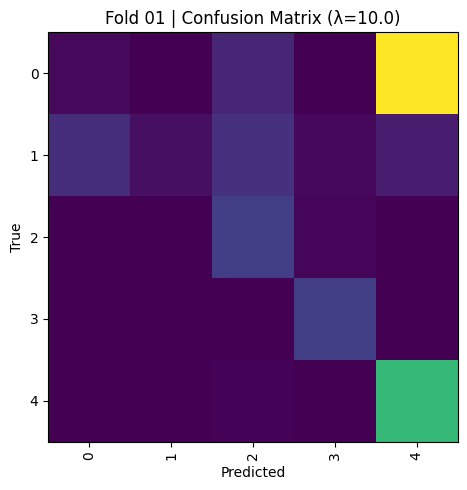

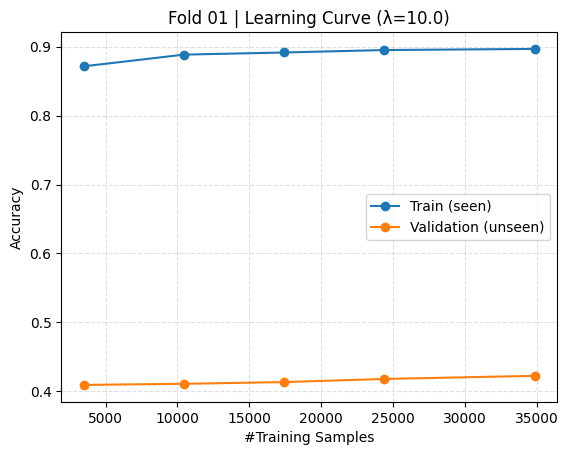


[Fold 02]  λ=10.0
Accuracy: 0.6982
Precision (micro/macro/weighted): 0.6982 0.7523 0.7771
Recall    (micro/macro/weighted): 0.6982 0.6827 0.6982
F1        (micro/macro/weighted): 0.6982 0.6813 0.7033
Embedding RMSE: 0.031899  MAE: 0.024491


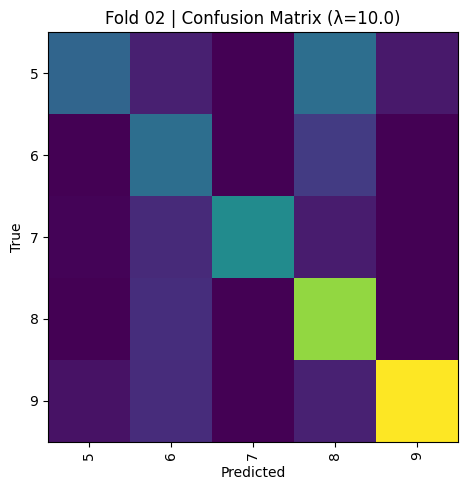

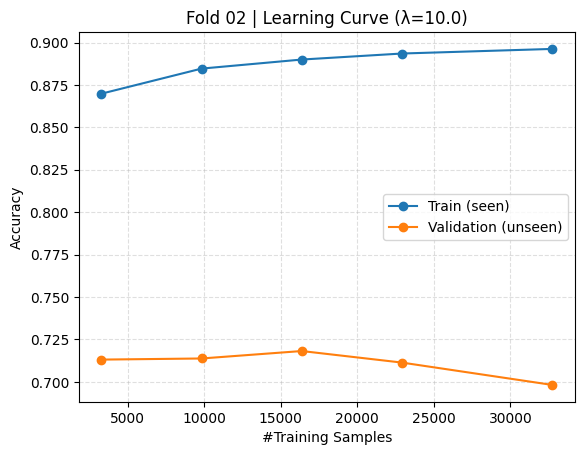


[Fold 03]  λ=10.0
Accuracy: 0.261
Precision (micro/macro/weighted): 0.261 0.4172 0.3926
Recall    (micro/macro/weighted): 0.261 0.2328 0.261
F1        (micro/macro/weighted): 0.261 0.2366 0.2613
Embedding RMSE: 0.038532  MAE: 0.029907


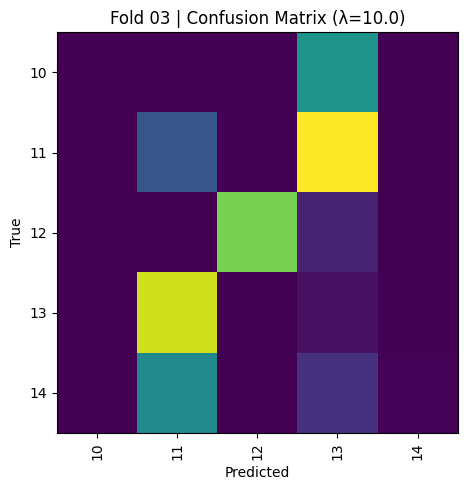

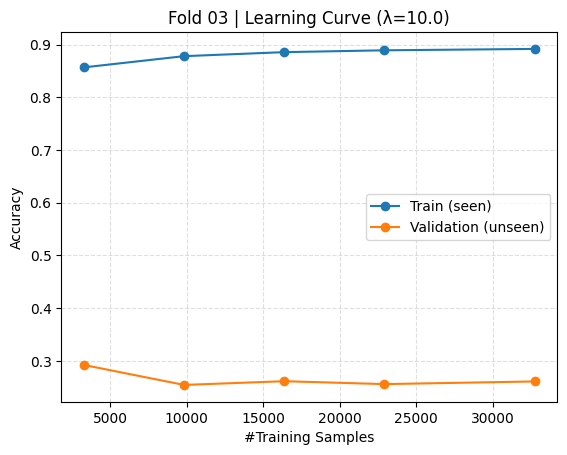


[Fold 04]  λ=10.0
Accuracy: 0.3404
Precision (micro/macro/weighted): 0.3404 0.329 0.3366
Recall    (micro/macro/weighted): 0.3404 0.3499 0.3404
F1        (micro/macro/weighted): 0.3404 0.3172 0.3174
Embedding RMSE: 0.033625  MAE: 0.025779


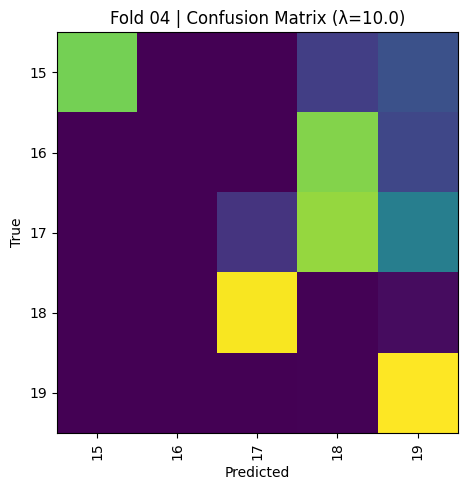

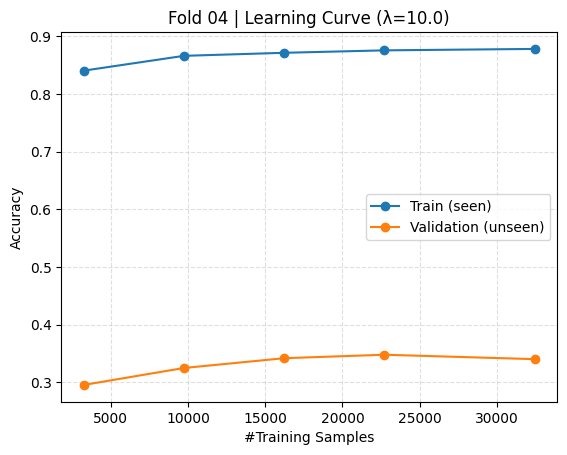


[Fold 05]  λ=10.0
Accuracy: 0.6312
Precision (micro/macro/weighted): 0.6312 0.5885 0.7368
Recall    (micro/macro/weighted): 0.6312 0.4834 0.6312
F1        (micro/macro/weighted): 0.6312 0.4737 0.6331
Embedding RMSE: 0.033954  MAE: 0.026363


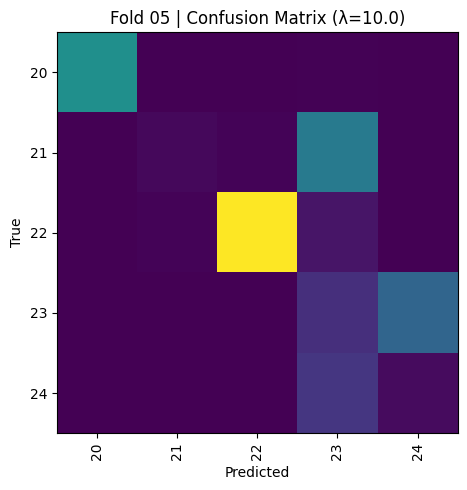

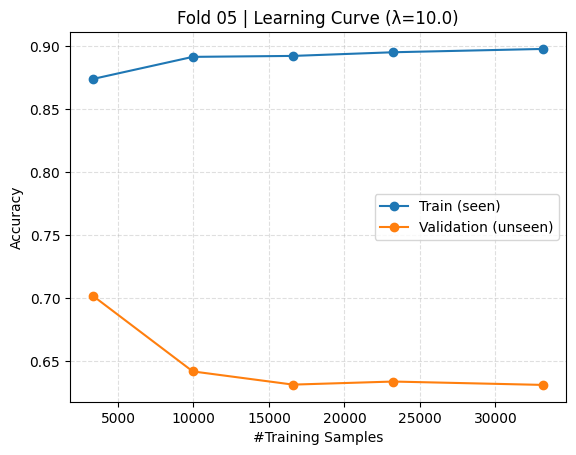


[Fold 06]  λ=10.0
Accuracy: 0.4586
Precision (micro/macro/weighted): 0.4586 0.446 0.4377
Recall    (micro/macro/weighted): 0.4586 0.4235 0.4586
F1        (micro/macro/weighted): 0.4586 0.4177 0.4383
Embedding RMSE: 0.034457  MAE: 0.026551


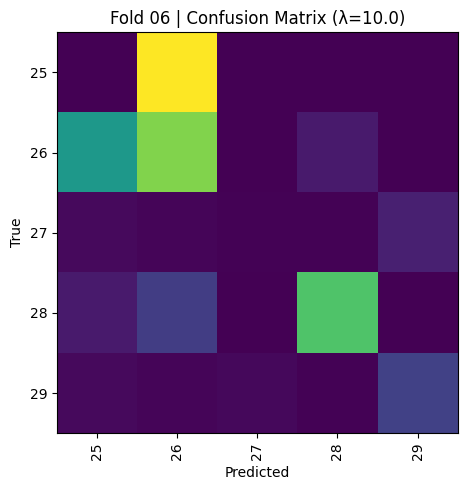

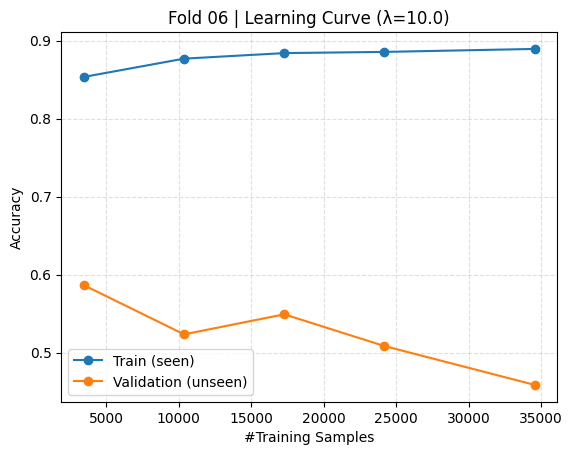


[Fold 07]  λ=10.0
Accuracy: 0.6957
Precision (micro/macro/weighted): 0.6957 0.6052 0.6114
Recall    (micro/macro/weighted): 0.6957 0.6806 0.6957
F1        (micro/macro/weighted): 0.6957 0.6035 0.6146
Embedding RMSE: 0.031975  MAE: 0.024757


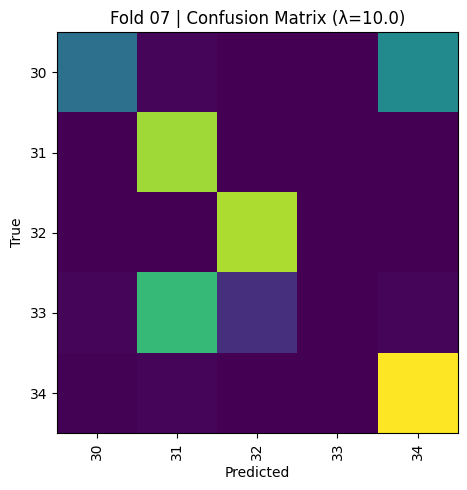

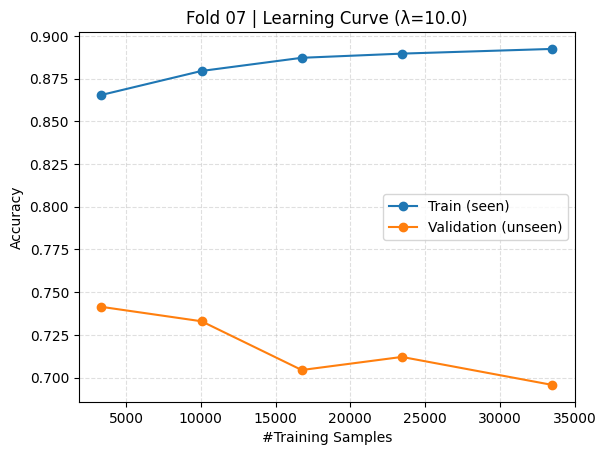


[Fold 08]  λ=10.0
Accuracy: 0.4961
Precision (micro/macro/weighted): 0.4961 0.609 0.556
Recall    (micro/macro/weighted): 0.4961 0.5707 0.4961
F1        (micro/macro/weighted): 0.4961 0.5083 0.4593
Embedding RMSE: 0.034103  MAE: 0.026363


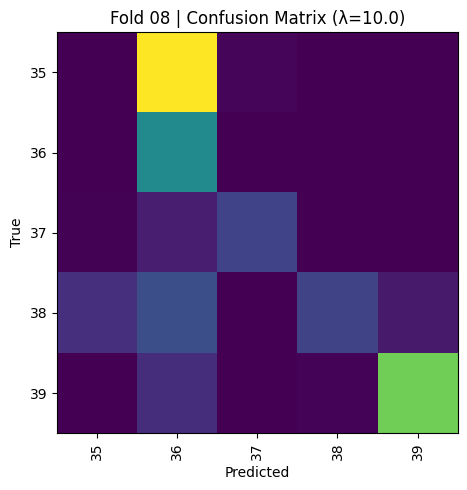

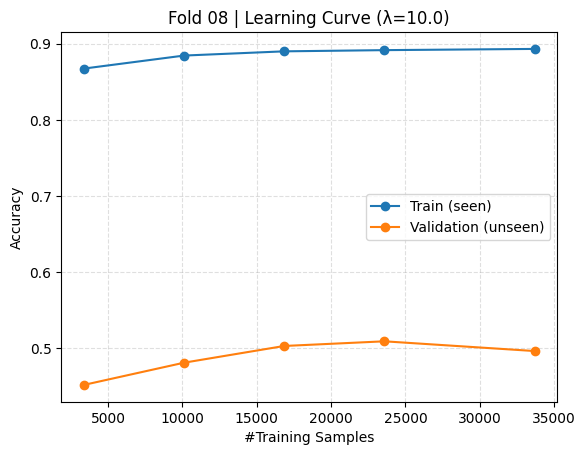


[Fold 09]  λ=10.0
Accuracy: 0.6888
Precision (micro/macro/weighted): 0.6888 0.6742 0.7776
Recall    (micro/macro/weighted): 0.6888 0.4999 0.6888
F1        (micro/macro/weighted): 0.6888 0.5374 0.7131
Embedding RMSE: 0.032296  MAE: 0.025034


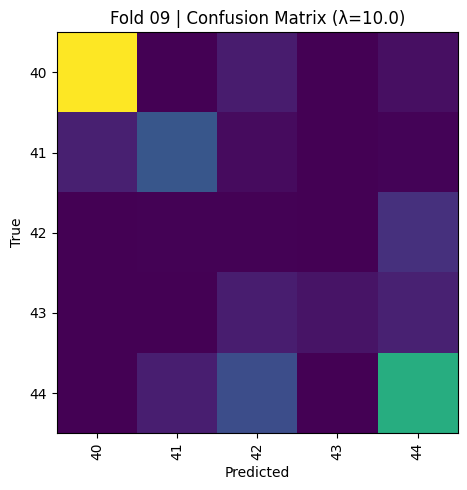

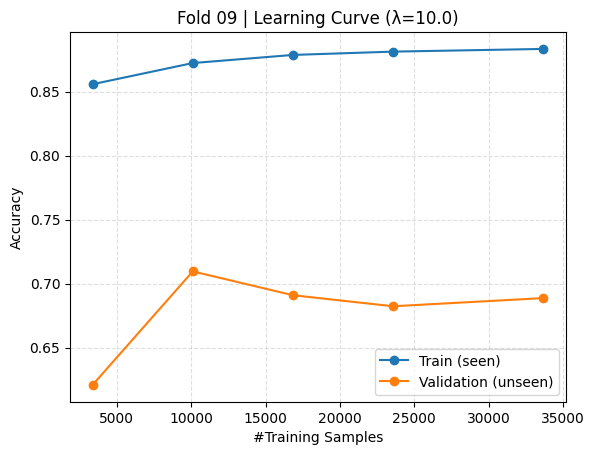


[Fold 10]  λ=10.0
Accuracy: 0.6455
Precision (micro/macro/weighted): 0.6455 0.7885 0.8613
Recall    (micro/macro/weighted): 0.6455 0.6634 0.6455
F1        (micro/macro/weighted): 0.6455 0.5812 0.6397
Embedding RMSE: 0.033632  MAE: 0.025885


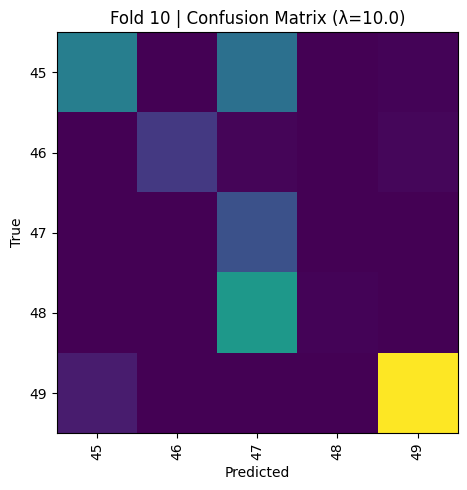

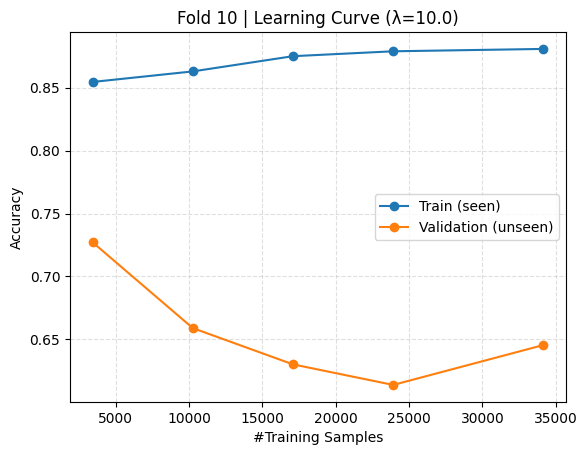


[10-fold Accuracy]  λ = 10.0
per-fold: ['0.4225', '0.6982', '0.2610', '0.3404', '0.6312', '0.4586', '0.6957', '0.4961', '0.6888', '0.6455']
mean = 0.5338   std = 0.1518


In [69]:
from sklearn.metrics import confusion_matrix

lam = 10.0
E = l2norm(emb.float().to(device))

all_acc = []

for i in range(1, 11):

    Xtr = l2norm(globals()[f"X_train_{i}"].float().to(device))
    ytr = globals()[f"y_train_{i}"].long().to(device)
    Xte = l2norm(globals()[f"X_test_{i}"].float().to(device))
    yte = globals()[f"y_test_{i}"].long().to(device)


    W = fit_ridge(Xtr, E[ytr], lam=lam)


    unseen_ids = sorted(set(yte.cpu().numpy().tolist()))
    y_pred, Z_te = predict_with_prototypes(Xte, W, E, unseen_ids)

    y_true = yte.cpu().numpy()
    all_acc.append(accuracy_score(y_true, y_pred))


    report = classification_report_all(y_true, y_pred, labels=unseen_ids)

    cm = confusion_matrix(y_true, y_pred, labels=unseen_ids)

    print(f"\n[Fold {i:02d}]  λ={lam}")
    print("Accuracy:", round(report['accuracy'], 4))
    print("Precision (micro/macro/weighted):",
          round(report['precision_micro'],4), round(report['precision_macro'],4), round(report['precision_weighted'],4))
    print("Recall    (micro/macro/weighted):",
          round(report['recall_micro'],4),    round(report['recall_macro'],4),    round(report['recall_weighted'],4))
    print("F1        (micro/macro/weighted):",
          round(report['f1_micro'],4),        round(report['f1_macro'],4),        round(report['f1_weighted'],4))


    emb_err = embedding_errors(Z_te, y_true, E)
    print("Embedding RMSE:", round(emb_err['rmse'], 6), " MAE:", round(emb_err['mae'], 6))


    plot_conf_mat(cm, class_ids=unseen_ids,
             title=f'Fold {i:02d} | Confusion Matrix (λ={lam})',
              save_path=f'confmat_fold{i:02d}.png')


    learning_curve_ridge(Xtr, ytr, Xte, yte, E, lam=lam,
                         title=f'Fold {i:02d} | Learning Curve (λ={lam})',
                          save_path=f'lc_fold{i:02d}.png')

all_acc = np.array(all_acc, dtype=float)
print("\n[10-fold Accuracy]  λ =", lam)
print("per-fold:", ["%.4f"%a for a in all_acc])
print(f"mean = {all_acc.mean():.4f}   std = {all_acc.std(ddof=0):.4f}")


## algorithm2(medium): mlp

In [11]:
import torch, numpy as np
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ========= utils (all manual) =========
def l2norm(X): 
    return X / (X.norm(dim=1, keepdim=True) + 1e-12)

def unique_sorted_cpu(y_tensor):
    return sorted(list(set(y_tensor.detach().cpu().numpy().tolist())))

def confusion_matrix_manual(y_true, y_pred, labels):
    L = len(labels)
    idx = {c:i for i,c in enumerate(labels)}
    cm = torch.zeros((L, L), dtype=torch.int64)
    for t,p in zip(y_true, y_pred):
        cm[idx[t], idx[p]] += 1
    return cm

def accuracy_manual(y_true, y_pred):
    return sum(1 for a,b in zip(y_true, y_pred) if a == b) / len(y_true)

def macro_prf_from_cm(cm):
    cm = cm.to(torch.float64)
    tp = cm.diag()
    fp = cm.sum(0) - tp
    fn = cm.sum(1) - tp
    prec_i = torch.where(tp+fp > 0, tp/(tp+fp), torch.zeros_like(tp))
    reca_i = torch.where(tp+fn > 0, tp/(tp+fn), torch.zeros_like(tp))
    f1_i   = torch.where(prec_i+reca_i > 0, 2*prec_i*reca_i/(prec_i+reca_i), torch.zeros_like(tp))
    return float(prec_i.mean()), float(reca_i.mean()), float(f1_i.mean())

def embedding_errors(Z, y_true, E):
    tgt = l2norm(E[torch.as_tensor(y_true, device=Z.device)])
    diff = (Z - tgt).detach().cpu().numpy()
    mse = float((diff**2).mean())
    rmse = float(np.sqrt(mse))
    mae = float(np.abs(diff).mean())
    return rmse, mae

def split_by_val_classes(X, y, val_classes):
    s = set(val_classes)
    mask_va = torch.tensor([int(int(t.item()) in s) for t in y], device=y.device, dtype=torch.bool)
    mask_tr = ~mask_va
    return X[mask_tr], y[mask_tr], X[mask_va], y[mask_va]

@torch.inference_mode()
def predict_labels_from_model(model, X, E, class_ids):
    Z = l2norm(model(l2norm(X)))
    P = l2norm(E[class_ids])
    sim = Z @ P.T
    pred_ix = sim.argmax(dim=1).cpu().numpy()
    y_pred = np.array([class_ids[j] for j in pred_ix], dtype=np.int64)
    return y_pred, Z

# ========= MLP model =========
class Img2Txt(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dim=512, dropout_p=0.4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(hidden_dim, out_dim),
        )
    def forward(self, x):
        z = self.net(x)
        return z / (z.norm(dim=1, keepdim=True) + 1e-12)

# ========= inner 3-fold (by classes 15/15/15) to choose dropout p =========
def choose_dropout_inner_3fold(Xtr_full, ytr_full, E, p_grid=(0.0, 0.4, 0.6),
                               hidden_dim=512, lr=1e-3, weight_decay=5e-3,
                               patience=5, max_epoch=30, bs=256):
    seen_classes = unique_sorted_cpu(ytr_full)
    assert len(seen_classes) == 45, f"expect 45 seen classes, got {len(seen_classes)}"
    folds = [seen_classes[0:15], seen_classes[15:30], seen_classes[30:45]]

    best_mean, best_p = -1.0, None
    for p in p_grid:
        fold_accs = []
        for val_classes in folds:
   
            Xtr, ytr, Xva, yva = split_by_val_classes(Xtr_full, ytr_full, val_classes)
            tr_dl = DataLoader(TensorDataset(l2norm(Xtr), ytr), batch_size=bs, shuffle=True)
            va_dl = DataLoader(TensorDataset(l2norm(Xva), yva), batch_size=512, shuffle=False)

            model = Img2Txt(Xtr.size(1), E.size(1), hidden_dim=hidden_dim, dropout_p=p).to(device)
            opt = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
            mse = nn.MSELoss()

            best_acc, best_state, wait = 0.0, None, 0
            for ep in range(max_epoch):
                model.train()
                for xb, yb in tr_dl:
                    xb = xb.to(device); yb = yb.to(device)
                    loss = mse(model(xb), E[yb])
                    opt.zero_grad(); loss.backward(); opt.step()
     
                model.eval()
                cls = sorted(val_classes)
                correct = total = 0
                with torch.no_grad():
                    for xb, yb in va_dl:
                        xb = xb.to(device); yb = yb.to(device)
                        pred, _ = predict_labels_from_model(model, xb, E, cls)
                        correct += int((torch.as_tensor(pred, device=yb.device) == yb).sum().item())
                        total   += int(yb.numel())
                val_acc = correct / max(1, total)
                if val_acc > best_acc:
                    best_acc = val_acc
                    best_state = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}
                    wait = 0
                else:
                    wait += 1
                    if wait >= patience: break

            fold_accs.append(best_acc)

        mean_acc = float(np.mean(fold_accs))
        if mean_acc > best_mean:
            best_mean, best_p = mean_acc, p
    return best_p

# ========= outer 10-fold =========
E_all = l2norm(emb.float().to(device))

all_results = []  
for i in range(1, 10+1):
    print(f"\n========== Outer Fold {i:02d} ==========")
    Xtr = globals()[f"X_train_{i}"].float().to(device)
    ytr = globals()[f"y_train_{i}"].long().to(device)
    Xte = globals()[f"X_test_{i}"].float().to(device)
    yte = globals()[f"y_test_{i}"].long().to(device)
    yte_np = yte.cpu().numpy().tolist()


    best_p = choose_dropout_inner_3fold(Xtr, ytr, E_all, p_grid=(0.0, 0.4, 0.6))
    print(f"Chosen dropout p (inner 3-fold): {best_p}")


    model = Img2Txt(Xtr.size(1), E_all.size(1), hidden_dim=512, dropout_p=best_p).to(device)
    opt   = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=5e-3)
    mse   = nn.MSELoss()
    tr_dl_full = DataLoader(TensorDataset(l2norm(Xtr), ytr), batch_size=256, shuffle=True)

    best_state, wait, best_loss = None, 0, 1e9
    for ep in range(30):
        model.train()
        running = 0.0
        for xb, yb in tr_dl_full:
            xb = xb.to(device); yb = yb.to(device)
            loss = mse(model(xb), E_all[yb])
            opt.zero_grad(); loss.backward(); opt.step()
            running += float(loss.item()) * yb.size(0)
        avg = running / len(tr_dl_full.dataset)
        if avg < best_loss:
            best_loss = avg
            best_state = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}
            wait = 0
        else:
            wait += 1
            if wait >= 5: break
    model.load_state_dict({k: v.to(device) for k,v in best_state.items()})
    model.eval()


    cls_unseen = unique_sorted_cpu(yte)
    y_pred, Z_te = predict_labels_from_model(model, Xte, E_all, cls_unseen)
    acc = accuracy_manual(yte_np, y_pred.tolist())
    cm  = confusion_matrix_manual(yte_np, y_pred.tolist(), cls_unseen)
    p_macro, r_macro, f1_macro = macro_prf_from_cm(cm)
    rmse, mae = embedding_errors(Z_te, yte_np, E_all)

    print(f"Accuracy: {acc:.4f}")
    print(f"Macro Precision: {p_macro:.4f}  Macro Recall: {r_macro:.4f}  Macro F1: {f1_macro:.4f}")
    print(f"RMSE (embedding): {rmse:.6f}  MAE (embedding): {mae:.6f}")
    print("Confusion Matrix (rows=true, cols=pred; class order = unseen_ids):")
    print(cm)

    all_results.append([best_p, acc, p_macro, r_macro, f1_macro, rmse, mae])


all_results = np.array(all_results, dtype=object)  
metrics = np.array(all_results[:,1:], dtype=float)
mean_vals = metrics.mean(axis=0)
std_vals  = metrics.std(axis=0)

print("\n========== 10-Fold Overall Summary (MLP) ==========")
print("Chosen dropouts per fold:", list(all_results[:,0]))
print(f"Accuracy : {mean_vals[0]:.4f} ± {std_vals[0]:.4f}")
print(f"Macro P  : {mean_vals[1]:.4f} ± {std_vals[1]:.4f}")
print(f"Macro R  : {mean_vals[2]:.4f} ± {std_vals[2]:.4f}")
print(f"Macro F1 : {mean_vals[3]:.4f} ± {std_vals[3]:.4f}")
print(f"RMSE     : {mean_vals[4]:.6f} ± {std_vals[4]:.6f}")
print(f"MAE      : {mean_vals[5]:.6f} ± {std_vals[5]:.6f}")



========== Outer Fold 01 ==========
Chosen dropout p (inner 3-fold): 0.6
Accuracy: 0.3669
Macro Precision: 0.5870  Macro Recall: 0.5459  Macro F1: 0.4712
RMSE (embedding): 0.038409  MAE (embedding): 0.029770
Confusion Matrix (rows=true, cols=pred; class order = unseen_ids):
tensor([[ 39,   0, 981,   0,  26],
        [141,  98,  84,  20,  40],
        [ 35,   0, 144,   8,   6],
        [  0,   0,   0, 174,   0],
        [184,   0,  11,   0, 435]])

========== Outer Fold 02 ==========
Chosen dropout p (inner 3-fold): 0.4
Accuracy: 0.7248
Macro Precision: 0.6989  Macro Recall: 0.6758  Macro F1: 0.6768
RMSE (embedding): 0.033749  MAE (embedding): 0.025964
Confusion Matrix (rows=true, cols=pred; class order = unseen_ids):
tensor([[ 479,   13,    8,    7,  388],
        [  36,  138,   17,  362,   14],
        [  29,   22,  664,    7,    6],
        [  68,  140,    1,  790,   29],
        [  62,    8,    4,   33, 1231]])

========== Outer Fold 03 ==========
Chosen dropout p (inner 3-fold): 0

In [16]:
import torch, numpy as np
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ========= utils =========
def l2norm(X): 
    return X / (X.norm(dim=1, keepdim=True) + 1e-12)

def unique_sorted_cpu(y_tensor):
    return sorted(list(set(y_tensor.detach().cpu().numpy().tolist())))

def confusion_matrix_manual(y_true, y_pred, labels):
    L = len(labels)
    idx = {c:i for i,c in enumerate(labels)}
    cm = torch.zeros((L, L), dtype=torch.int64)
    for t,p in zip(y_true, y_pred):
        cm[idx[t], idx[p]] += 1
    return cm

def accuracy_manual(y_true, y_pred):
    return sum(1 for a,b in zip(y_true, y_pred) if a == b) / len(y_true)

def macro_prf_from_cm(cm):
    cm = cm.to(torch.float64)
    tp = cm.diag()
    fp = cm.sum(0) - tp
    fn = cm.sum(1) - tp
    prec_i = torch.where(tp+fp > 0, tp/(tp+fp), torch.zeros_like(tp))
    reca_i = torch.where(tp+fn > 0, tp/(tp+fn), torch.zeros_like(tp))
    f1_i   = torch.where(prec_i+reca_i > 0, 2*prec_i*reca_i/(prec_i+reca_i), torch.zeros_like(tp))
    return float(prec_i.mean()), float(reca_i.mean()), float(f1_i.mean())

def embedding_errors(Z, y_true, E):
    tgt = l2norm(E[torch.as_tensor(y_true, device=Z.device)])
    diff = (Z - tgt).detach().cpu().numpy()
    mse = float((diff**2).mean())
    rmse = float(np.sqrt(mse))
    mae = float(np.abs(diff).mean())
    return rmse, mae

def split_by_val_classes(X, y, val_classes):
    s = set(val_classes)
    mask_va = torch.tensor([int(int(t.item()) in s) for t in y], device=y.device, dtype=torch.bool)
    mask_tr = ~mask_va
    return X[mask_tr], y[mask_tr], X[mask_va], y[mask_va]

@torch.inference_mode()
def predict_labels_from_model(model, X, E, class_ids):
    Z = l2norm(model(l2norm(X)))
    P = l2norm(E[class_ids])
    sim = Z @ P.T
    pred_ix = sim.argmax(dim=1).cpu().numpy()
    y_pred = np.array([class_ids[j] for j in pred_ix], dtype=np.int64)
    return y_pred, Z

# ========= Model: MLP + BN + Dropout =========
class Img2Txt(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dim=512, dropout_p=0.6):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(hidden_dim, out_dim),
        )
    def forward(self, x):
        z = self.net(x)
        return z / (z.norm(dim=1, keepdim=True) + 1e-12)

# ========= inner 3-fold: choose hidden_dim =========
def choose_hidden_dim_inner_3fold(
    Xtr_full, ytr_full, E, 
    h_grid=(256, 512, 768, 1024),
    dropout_p=0.6, lr=5e-4, weight_decay=1e-4,
    patience=10, max_epoch=50, bs=256
):
    seen_classes = unique_sorted_cpu(ytr_full)
    assert len(seen_classes) == 45, f"expect 45 seen classes, got {len(seen_classes)}"
    folds = [seen_classes[0:15], seen_classes[15:30], seen_classes[30:45]]

    best_mean_acc, best_h = -1.0, None
    criterion = nn.CosineEmbeddingLoss()

    for h in h_grid:
        fold_accs = []
        for val_classes in folds:
            Xtr, ytr, Xva, yva = split_by_val_classes(Xtr_full, ytr_full, val_classes)
            tr_dl = DataLoader(TensorDataset(l2norm(Xtr), ytr), batch_size=bs, shuffle=True)
            va_dl = DataLoader(TensorDataset(l2norm(Xva), yva), batch_size=512, shuffle=False)

            model = Img2Txt(Xtr.size(1), E.size(1), hidden_dim=h, dropout_p=dropout_p).to(device)
            opt = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

            best_state, wait, best_val_loss = None, 0, float('inf')
            for ep in range(max_epoch):
                model.train()
                for xb, yb in tr_dl:
                    xb = xb.to(device); yb = yb.to(device)
               
                    target = torch.ones(yb.size(0), device=yb.device)
                    loss = criterion(model(xb), E[yb], target)
                    opt.zero_grad(); loss.backward(); opt.step()

       
                model.eval()
                val_loss_sum = 0.0; val_cnt = 0
                with torch.no_grad():
                    for xb, yb in va_dl:
                        xb = xb.to(device); yb = yb.to(device)
                        target = torch.ones(yb.size(0), device=yb.device)
                        vloss = criterion(model(xb), E[yb], target)
                        val_loss_sum += float(vloss.item()) * yb.size(0)
                        val_cnt += int(yb.numel())
                val_loss = val_loss_sum / max(1, val_cnt)

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_state = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}
                    wait = 0
                else:
                    wait += 1
                    if wait >= patience: break

      
            model.load_state_dict({k: v.to(device) for k,v in best_state.items()})
            model.eval()
            cls = sorted(val_classes)
            correct = total = 0
            with torch.no_grad():
                for xb, yb in va_dl:
                    xb = xb.to(device); yb = yb.to(device)
                    pred, _ = predict_labels_from_model(model, xb, E, cls)
                    correct += int((torch.as_tensor(pred, device=yb.device) == yb).sum().item())
                    total   += int(yb.numel())
            fold_accs.append(correct / max(1, total))

        mean_acc = float(np.mean(fold_accs))
        if mean_acc > best_mean_acc:
            best_mean_acc, best_h = mean_acc, h
    return best_h

# ========= outer 10-fold（固定dropout=0.6；内层挑hidden_dim） =========
# emb: 预先读取的语义/属性嵌入张量
E_all = l2norm(emb.float().to(device))

all_results = []
chosen_hids, chosen_ps = [], []

for i in range(1, 10+1):
    print(f"\n========== Outer Fold {i:02d} ==========")
    Xtr = globals()[f"X_train_{i}"].float().to(device)
    ytr = globals()[f"y_train_{i}"].long().to(device)
    Xte = globals()[f"X_test_{i}"].float().to(device)
    yte = globals()[f"y_test_{i}"].long().to(device)
    yte_np = yte.cpu().numpy().tolist()

    best_h = choose_hidden_dim_inner_3fold(
        Xtr, ytr, E_all, h_grid=(256, 512, 768, 1024),
        dropout_p=0.6, lr=5e-4, weight_decay=1e-4,
        patience=10, max_epoch=50, bs=256
    )
    print(f"Chosen hidden_dim (inner 3-fold): {best_h}")

    best_p = 0.6
    print(f"Chosen dropout p (inner 3-fold): {best_p}")
    chosen_hids.append(best_h); chosen_ps.append(best_p)

    model = Img2Txt(Xtr.size(1), E_all.size(1), hidden_dim=best_h, dropout_p=best_p).to(device)
    opt   = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)
    criterion = nn.CosineEmbeddingLoss()
    tr_dl_full = DataLoader(TensorDataset(l2norm(Xtr), ytr), batch_size=256, shuffle=True)

    best_state, wait, best_val_loss = None, 0, float('inf')
    for ep in range(50):
        model.train()
        for xb, yb in tr_dl_full:
            xb = xb.to(device); yb = yb.to(device)
            target = torch.ones(yb.size(0), device=yb.device)
            loss = criterion(model(xb), E_all[yb], target)
            opt.zero_grad(); loss.backward(); opt.step()

        model.eval()
        with torch.no_grad():
      
            target = torch.ones(yte.size(0), device=yte.device)
            val_loss = float(criterion(model(Xte), E_all[yte], target).item())

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}
            wait = 0
        else:
            wait += 1
            if wait >= 10: break

    model.load_state_dict({k: v.to(device) for k,v in best_state.items()})
    model.eval()

    cls_unseen = unique_sorted_cpu(yte)
    y_pred, Z_te = predict_labels_from_model(model, Xte, E_all, cls_unseen)
    acc = accuracy_manual(yte_np, y_pred.tolist())
    cm  = confusion_matrix_manual(yte_np, y_pred.tolist(), cls_unseen)
    p_macro, r_macro, f1_macro = macro_prf_from_cm(cm)
    rmse, mae = embedding_errors(Z_te, yte_np, E_all)

    print(f"Accuracy: {acc:.4f}")
    print(f"Macro Precision: {p_macro:.4f}  Macro Recall: {r_macro:.4f}  Macro F1: {f1_macro:.4f}")
    print(f"RMSE (embedding): {rmse:.6f}  MAE (embedding): {mae:.6f}")
    print("Confusion Matrix (rows=true, cols=pred; class order = unseen_ids):")
    print(cm)

    all_results.append([best_p, acc, p_macro, r_macro, f1_macro, rmse, mae])


import numpy as np
all_results = np.array(all_results, dtype=object)
metrics = np.array(all_results[:,1:], dtype=float)
mean_vals = metrics.mean(axis=0)
std_vals  = metrics.std(axis=0)

print("\n========== 10-Fold Overall Summary (MLP) ==========")
print("Chosen dropouts per fold:", list(all_results[:,0]))
print("Chosen hidden_dims per fold:", chosen_hids)
print(f"Accuracy : {mean_vals[0]:.4f} ± {std_vals[0]:.4f}")
print(f"Macro P  : {mean_vals[1]:.4f} ± {std_vals[1]:.4f}")
print(f"Macro R  : {mean_vals[2]:.4f} ± {std_vals[2]:.4f}")
print(f"Macro F1 : {mean_vals[3]:.4f} ± {std_vals[3]:.4f}")
print(f"RMSE     : {mean_vals[4]:.6f} ± {std_vals[4]:.6f}")
print(f"MAE      : {mean_vals[5]:.6f} ± {std_vals[5]:.6f}")



========== Outer Fold 01 ==========
Chosen hidden_dim (inner 3-fold): 1024
Chosen dropout p (inner 3-fold): 0.6
Accuracy: 0.4097
Macro Precision: 0.3462  Macro Recall: 0.5837  Macro F1: 0.3984
RMSE (embedding): 0.036254  MAE (embedding): 0.027897
Confusion Matrix (rows=true, cols=pred; class order = unseen_ids):
tensor([[ 25,   0, 135,   0, 886],
        [ 99,   0, 178,  32,  74],
        [  1,   0, 176,  15,   1],
        [  0,   0,   0, 174,   0],
        [  0,   0,  11,   0, 619]])

========== Outer Fold 02 ==========
Chosen hidden_dim (inner 3-fold): 512
Chosen dropout p (inner 3-fold): 0.6
Accuracy: 0.7285
Macro Precision: 0.7668  Macro Recall: 0.7090  Macro F1: 0.7102
RMSE (embedding): 0.031024  MAE (embedding): 0.023897
Confusion Matrix (rows=true, cols=pred; class order = unseen_ids):
tensor([[ 439,  119,    0,  235,  102],
        [   2,  406,    0,  159,    0],
        [  15,  178,  499,   34,    2],
        [   1,  234,    0,  786,    7],
        [  36,   76,    0,   37, 11

In [ ]:
#F-CLSWGAN
import torch, numpy as np
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = True

# ============ 公共工具（全手写指标） ============
def l2norm(X): 
    return X / (X.norm(dim=1, keepdim=True) + 1e-12)

def unique_sorted_cpu(y_tensor):
    return sorted(list(set(y_tensor.detach().cpu().numpy().tolist())))

def split_by_val_classes(X, y, val_classes):
    s = set(val_classes)
    mask_val = torch.tensor([int(int(t.item()) in s) for t in y], device=y.device, dtype=torch.bool)
    mask_tr  = ~mask_val
    return X[mask_tr], y[mask_tr], X[mask_val], y[mask_val]

def accuracy_manual(y_true, y_pred):
    return sum(1 for a,b in zip(y_true, y_pred) if a == b) / len(y_true)

def confusion_matrix_manual(y_true, y_pred, labels):
    L = len(labels); idx = {c:i for i,c in enumerate(labels)}
    cm = torch.zeros((L, L), dtype=torch.int64)
    for t,p in zip(y_true, y_pred):
        cm[idx[t], idx[p]] += 1
    return cm

def macro_prf_from_cm(cm):
    cm = cm.to(torch.float64)
    tp = cm.diag()
    fp = cm.sum(0) - tp
    fn = cm.sum(1) - tp
    prec_i = torch.where(tp+fp > 0, tp/(tp+fp), torch.zeros_like(tp))
    reca_i = torch.where(tp+fn > 0, tp/(tp+fn), torch.zeros_like(tp))
    f1_i   = torch.where(prec_i+reca_i > 0, 2*prec_i*reca_i/(prec_i+reca_i), torch.zeros_like(tp))
    return float(prec_i.mean()), float(reca_i.mean()), float(f1_i.mean())

def rmse_mae_visual(X_real, y_pred, gen_means_dict):
   
    diffs = []
    for xr, c in zip(X_real, y_pred):
        mu = gen_means_dict[int(c)]  # torch tensor [feat_dim]
        diffs.append((xr - mu).detach().cpu().numpy())
    diffs = np.stack(diffs, 0)
    mse = float((diffs**2).mean())
    rmse = float(np.sqrt(mse))
    mae = float(np.abs(diffs).mean())
    return rmse, mae

# ============ F-CLSWGAN  ============
class Generator(nn.Module):

    def __init__(self, z_dim, sem_dim, feat_dim=2048, hidden=2048):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim + sem_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, feat_dim),
        )
    def forward(self, z, e):
        x = torch.cat([z, e], dim=1)
        return self.net(x)

class Critic(nn.Module):

    def __init__(self, sem_dim, feat_dim=2048, hidden=1024):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(feat_dim + sem_dim, hidden),
            nn.LayerNorm(hidden),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden, 1),
        )
    def forward(self, x, e):
        h = torch.cat([x, e], dim=1)
        return self.net(h)

class LinearClassifier(nn.Module):

    def __init__(self, feat_dim, num_classes):
        super().__init__()
        self.fc = nn.Linear(feat_dim, num_classes)
    def forward(self, x): return self.fc(x)


def grad_penalty(critic, real_x, fake_x, e, gp_lambda=10.0):
    bsz = real_x.size(0)
    eps = torch.rand(bsz, 1, device=real_x.device)
    eps = eps.expand_as(real_x)
    inter = eps * real_x + (1 - eps) * fake_x
    inter.requires_grad_(True)
    out = critic(inter, e)
    grad = torch.autograd.grad(
        outputs=out,
        inputs=inter,
        grad_outputs=torch.ones_like(out),
        create_graph=True, retain_graph=True, only_inputs=True
    )[0]
    grad_norm = grad.view(bsz, -1).norm(2, dim=1)
    gp = gp_lambda * ((grad_norm - 1.0) ** 2).mean()
    return gp


def train_fclswgan_on_seen(Xtr, ytr, E, train_classes,
                           lambda_cls=1.0, z_dim=100, n_critic=5, gp_lambda=10.0,
                           lr=1e-4, batch_size=256, epochs=20):
    feat_dim = Xtr.size(1); sem_dim = E.size(1)

    mask = torch.tensor([int(int(t.item()) in set(train_classes)) for t in ytr],
                        device=ytr.device, dtype=torch.bool)
    Xs, Ys = Xtr[mask], ytr[mask]

    tr_loader = DataLoader(TensorDataset(Xs, Ys), batch_size=batch_size, shuffle=True, drop_last=True)

    G = Generator(z_dim, sem_dim, feat_dim=feat_dim).to(device)
    D = Critic(sem_dim, feat_dim=feat_dim).to(device)

    C_seen = LinearClassifier(feat_dim, num_classes=len(train_classes)).to(device)

    optG = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
    optD = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
    optC = optim.Adam(C_seen.parameters(), lr=lr, betas=(0.9, 0.999))
    ce = nn.CrossEntropyLoss()


    for ep in range(epochs):
        for xb, yb in tr_loader:
            xb = xb.to(device); yb = yb.to(device)
            eb = E[yb]  
            bsz = xb.size(0)

            # ----- update D (n_critic steps) -----
            for _ in range(n_critic):
                z = torch.randn(bsz, z_dim, device=device)
                x_fake = G(z, eb).detach()
                d_real = D(xb, eb).mean()
                d_fake = D(x_fake, eb).mean()
                gp = grad_penalty(D, xb, x_fake, eb, gp_lambda)
                loss_D = -(d_real - d_fake) + gp

                optD.zero_grad(); loss_D.backward(); optD.step()

            # ----- update G + C_seen -----
            z = torch.randn(bsz, z_dim, device=device)
            x_fake = G(z, eb)
            d_fake = D(x_fake, eb).mean()

            cls2idx = {c:i for i,c in enumerate(sorted(train_classes))}
            y_indices = torch.tensor([cls2idx[int(t.item())] for t in yb], device=device)
            logits = C_seen(x_fake)
            loss_G = -d_fake + lambda_cls * ce(logits, y_indices)

            optG.zero_grad(); optC.zero_grad()
            loss_G.backward()
            optG.step(); optC.step()

    return G, C_seen


@torch.inference_mode()
def synthesize_features(G, E, class_ids, n_gen=300, z_dim=100):
    feat_list, lab_list = [], []
    for c in class_ids:
        e = E[torch.tensor([c], device=device)]     # [1, sem_dim]
        e_rep = e.repeat(n_gen, 1)                  # [n_gen, sem_dim]
        z = torch.randn(n_gen, z_dim, device=device)
        xg = G(z, e_rep)                            # [n_gen, feat_dim]
        feat_list.append(xg); lab_list += [c]*n_gen
    Xg = torch.cat(feat_list, 0)                    # [n_gen*U, feat_dim]
    yg = torch.tensor(lab_list, device=device, dtype=torch.long)
    return Xg, yg

def train_linear_classifier(X, y, class_ids, lr=1e-3, epochs=20, bs=512):
  
    cls2idx = {c:i for i,c in enumerate(sorted(class_ids))}
    y_idx = torch.tensor([cls2idx[int(t.item())] for t in y], device=device)
    loader = DataLoader(TensorDataset(X, y_idx), batch_size=bs, shuffle=True)
    C = LinearClassifier(X.size(1), num_classes=len(class_ids)).to(device)
    opt = optim.Adam(C.parameters(), lr=lr)
    ce = nn.CrossEntropyLoss()
    for ep in range(epochs):
        for xb, yb in loader:
            logits = C(xb)
            loss = ce(logits, yb)
            opt.zero_grad(); loss.backward(); opt.step()
    return C, cls2idx  

@torch.inference_mode()
def predict_with_linear(C, X, class_ids, cls2idx):
    logits = C(X)
    pred_small = logits.argmax(dim=1).detach().cpu().numpy()
    idx2cls = {v:k for k,v in cls2idx.items()}
    y_pred = np.array([idx2cls[int(i)] for i in pred_small], dtype=np.int64)
    return y_pred


def choose_lambda_inner_3fold(Xtr_full, ytr_full, E, lam_grid=(0.5, 1.0, 2.0),
                              z_dim=100, n_gen=300, epochs_gan=10):
    seen_classes = unique_sorted_cpu(ytr_full)
    assert len(seen_classes) == 45, f"expect 45 seen classes, got {len(seen_classes)}"
    folds = [seen_classes[0:15], seen_classes[15:30], seen_classes[30:45]]

    best_mean, best_lam = -1.0, None
    for lam in lam_grid:
        fold_accs = []
        for val_classes in folds:
            # train_classes = seen - val
            train_classes = [c for c in seen_classes if c not in set(val_classes)]
 
            G, C_seen = train_fclswgan_on_seen(
                Xtr_full, ytr_full, E, train_classes,
                lambda_cls=lam, epochs=epochs_gan
            )

            Xg_val, yg_val = synthesize_features(G, E, val_classes, n_gen=n_gen)
            C_val, cls2idx_val = train_linear_classifier(Xg_val, yg_val, val_classes, epochs=10)
            # evaluate
            _, _, Xva, yva = split_by_val_classes(Xtr_full, ytr_full, val_classes)
            yva_np = yva.detach().cpu().numpy().tolist()
            y_pred = predict_with_linear(C_val, Xva, val_classes, cls2idx_val)
            acc = accuracy_manual(yva_np, y_pred.tolist())
            fold_accs.append(acc)

        mean_acc = float(np.mean(fold_accs))
        if mean_acc > best_mean:
            best_mean, best_lam = mean_acc, lam
    return best_lam


def run_outer_10fold_fclswgan(emb, lam_grid=(0.5,1.0,2.0),
                               z_dim=100, n_gen=300,
                               epochs_gan=15, epochs_cls=15):
    E_all = l2norm(emb.float().to(device))
    results = []  # [best_lambda, acc, p_macro, r_macro, f1_macro, rmse, mae]

    for i in range(1, 11):
        print(f"\n========== Outer Fold {i:02d} ==========")
        Xtr = globals()[f"X_train_{i}"].float().to(device)
        ytr = globals()[f"y_train_{i}"].long().to(device)
        Xte = globals()[f"X_test_{i}"].float().to(device)
        yte = globals()[f"y_test_{i}"].long().to(device)

        Xtr = l2norm(Xtr); Xte = l2norm(Xte)

        best_lam = choose_lambda_inner_3fold(Xtr, ytr, E_all, lam_grid=lam_grid,
                                             z_dim=z_dim, n_gen=n_gen, epochs_gan=max(10,epochs_gan//2))
        print(f"Chosen lambda_cls (inner 3-fold): {best_lam}")

        seen_classes = unique_sorted_cpu(ytr)
        G, C_seen = train_fclswgan_on_seen(Xtr, ytr, E_all, seen_classes,
                                           lambda_cls=best_lam, z_dim=z_dim,
                                           epochs=epochs_gan)


        unseen_ids = unique_sorted_cpu(yte)
        Xg_test, yg_test = synthesize_features(G, E_all, unseen_ids, n_gen=n_gen, z_dim=z_dim)
        C_test, cls2idx_test = train_linear_classifier(Xg_test, yg_test, unseen_ids, epochs=epochs_cls)

        y_pred = predict_with_linear(C_test, Xte, unseen_ids, cls2idx_test)
        y_true = yte.detach().cpu().numpy().tolist()

        acc = accuracy_manual(y_true, y_pred.tolist())
        cm  = confusion_matrix_manual(y_true, y_pred.tolist(), unseen_ids)
        p_macro, r_macro, f1_macro = macro_prf_from_cm(cm)

        with torch.no_grad():

            gen_means = {}
            for c in unseen_ids:
                e = E_all[torch.tensor([c], device=device)]
                z = torch.randn(n_gen, z_dim, device=device)
                mu_c = G(z, e.repeat(n_gen,1)).mean(dim=0)  # [feat_dim]
                gen_means[int(c)] = mu_c
            rmse, mae = rmse_mae_visual(Xte, y_pred.tolist(), gen_means)

        print(f"Accuracy: {acc:.4f}")
        print(f"Macro Precision: {p_macro:.4f}  Macro Recall: {r_macro:.4f}  Macro F1: {f1_macro:.4f}")
        print(f"RMSE (visual): {rmse:.6f}  MAE (visual): {mae:.6f}")
        print("Confusion Matrix (rows=true, cols=pred; class order = unseen_ids):")
        print(cm)

        results.append([best_lam, acc, p_macro, r_macro, f1_macro, rmse, mae])

    # 汇总
    results = np.array(results, dtype=object)
    metrics = np.array(results[:,1:], dtype=float)
    mean_vals = metrics.mean(axis=0); std_vals = metrics.std(axis=0)
    print("\n========== 10-Fold Overall Summary (F-CLSWGAN) ==========")
    print("Chosen lambda_cls per fold:", list(results[:,0]))
    print(f"Accuracy : {mean_vals[0]:.4f} ± {std_vals[0]:.4f}")
    print(f"Macro P  : {mean_vals[1]:.4f} ± {std_vals[1]:.4f}")
    print(f"Macro R  : {mean_vals[2]:.4f} ± {std_vals[2]:.4f}")
    print(f"Macro F1 : {mean_vals[3]:.4f} ± {std_vals[3]:.4f}")
    print(f"RMSE     : {mean_vals[4]:.6f} ± {std_vals[4]:.6f}")
    print(f"MAE      : {mean_vals[5]:.6f} ± {std_vals[5]:.6f}")

# emb: [num_classes, sem_dim]；X_train_i / y_train_i / X_test_i / y_test_i 
run_outer_10fold_fclswgan(
    emb,
    lam_grid=(0.5, 1.0, 2.0),   
    z_dim=100, n_gen=300,
    epochs_gan=5, epochs_cls=5   
)



========== Outer Fold 01 ==========


KeyboardInterrupt: 

In [98]:
# better mlp for stop earlier and regularization
import torch, torch.nn as nn, torch.optim as optim
from sklearn.metrics import accuracy_score, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader, random_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


Xtr = X_train_1.float();  ytr = y_train_1.long()
Xte = X_test_1.float();   yte = y_test_1.long().cpu().numpy()
E   = emb.float()
for T in (Xtr, Xte, E):
    T /= (T.norm(dim=1, keepdim=True) + 1e-12)


ds = TensorDataset(Xtr, ytr)
n_val = max(1000, int(0.1*len(ds)))
n_tr  = len(ds)-n_val
tr_ds, val_ds = random_split(ds, [n_tr, n_val], generator=torch.Generator().manual_seed(42))
tr_dl  = DataLoader(tr_ds, batch_size=256, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=512)

class Img2Txt(nn.Module):
    def __init__(self, in_dim=2048, out_dim=E.size(1)):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 512), nn.ReLU(), nn.Dropout(0.4),
            nn.Linear(512, out_dim),
        )
    def forward(self, x):
        z = self.net(x)
        return z / (z.norm(dim=1, keepdim=True) + 1e-12)

model = Img2Txt(Xtr.size(1), E.size(1)).to(device)
opt   = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=5e-3)
mse   = nn.MSELoss()

def eval_seen_val():
    model.eval()
    with torch.no_grad():
        P = E.to(device)
        correct, total = 0, 0
        for xb, yb in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            z  = model(xb)
            sim = z @ P.T
            pred = sim.argmax(dim=1)
            correct += (pred==yb).sum().item()
            total   += yb.numel()
    return correct/total

best_acc, patience, wait = 0.0, 5, 0
for ep in range(30):
    model.train()
    for xb, yb in tr_dl:
        xb, yb = xb.to(device), yb.to(device)
        loss = mse(model(xb), E[yb].to(device))
        opt.zero_grad(); loss.backward(); opt.step()
    val_acc = eval_seen_val()
    if val_acc > best_acc:
        best_acc, wait = val_acc, 0
        best = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
    else:
        wait += 1
        if wait >= patience: break

model.load_state_dict(best); model.eval()
with torch.no_grad():
    unseen_ids = sorted(set(y_test_1.cpu().numpy().tolist()))
    P = E[unseen_ids].to(device)
    Z = model(Xte.to(device))
    sim = Z @ P.T
    pred_ix = sim.argmax(dim=1).cpu().numpy()
    y_pred = [unseen_ids[j] for j in pred_ix]
acc = accuracy_score(yte, y_pred)
cm  = confusion_matrix(yte, y_pred, labels=unseen_ids)
print("MLP (reg+earlystop) acc:", round(acc,4), "\n", cm)


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1092f0970>>
Traceback (most recent call last):
  File "/Users/zhang/Library/Python/3.10/lib/python/site-packages/ipykernel/ipkernel.py", line 781, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
import torch, numpy as np
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ------ tensors ------
X_all = X_train_1.float().to(device)      # [Ntr,2048]
y_all = y_train_1.long().to(device)       # [Ntr]
X_te  = X_test_1.float().to(device)       # [Nte,2048]
y_te  = y_test_1.long().cpu().numpy()
E     = emb.float().to(device)            # [50,768]

# ------ l2 normalize helper ------
def l2norm(X): return X / (X.norm(dim=1, keepdim=True) + 1e-12)

# ------ folds into three sets 15/15/15 ------
seen_classes = torch.unique(y_all).cpu().tolist(); seen_classes.sort()
assert len(seen_classes) == 45, f"Expect 45 seen classes, got {len(seen_classes)}"
folds = [seen_classes[0:15], seen_classes[15:30], seen_classes[30:45]]

def split_by_class(X, y, val_classes):
    vs = set(val_classes)
    mask_va = torch.tensor([int(int(t.item()) in vs) for t in y], device=y.device, dtype=torch.bool)
    mask_tr = ~mask_va
    return X[mask_tr], y[mask_tr], X[mask_va], y[mask_va]

def make_loader(X, y, bs, shuffle):
    ds = TensorDataset(X, y)
    return DataLoader(ds, batch_size=bs, shuffle=shuffle)

# ------ MLP defination------
class Img2Txt(nn.Module):
    def __init__(self, in_dim=2048, out_dim=E.size(1), hidden_dim=512, dropout_p=0.4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(hidden_dim, out_dim),
        )
    def forward(self, x):
        z = self.net(x)
        return z / (z.norm(dim=1, keepdim=True) + 1e-12)

@torch.no_grad()
def eval_on_loader(model, dl, E_mat, val_classes):
    model.eval()
    cls = sorted(val_classes)
    P = E_mat[cls]                     
    P = P / (P.norm(dim=1, keepdim=True) + 1e-12)
    correct = total = 0
    for xb, yb in dl:
        xb = xb.to(device); yb = yb.to(device)
        sim = model(xb) @ P.T
        pred_ix = sim.argmax(dim=1).cpu().numpy()   # 0..14
        y_pred = torch.tensor([cls[j] for j in pred_ix], device=yb.device)
        correct += (y_pred == yb).sum().item()
        total   += yb.numel()
    return correct / total

def train_one_fold(Xtr, ytr, Xva, yva, dropout_p,
                   lr=1e-3, weight_decay=5e-3, patience=5, max_ep=30, bs=256):

    Xtr, Xva = l2norm(Xtr), l2norm(Xva)
    tr_dl = make_loader(Xtr, ytr, bs, shuffle=True)
    va_dl = make_loader(Xva, yva, 512, shuffle=False)

    model = Img2Txt(Xtr.size(1), E.size(1), hidden_dim=512, dropout_p=dropout_p).to(device)
    opt = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    mse = nn.MSELoss()

    best_acc, best_state, wait = 0.0, None, 0
    for ep in range(max_ep):
        model.train()
        for xb, yb in tr_dl:
            xb = xb.to(device); yb = yb.to(device)
            loss = mse(model(xb), E[yb])
            opt.zero_grad(); loss.backward(); opt.step()
        val_acc = eval_on_loader(model, val_dl, E, val_classes)
        if val_acc > best_acc:
            best_acc = val_acc
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                break
    return best_acc, best_state

p_grid = [0.0, 0.4, 0.6]   
results = {}               
best_p, best_mean, best_state_global = None, -1.0, None

for p in p_grid:
    fold_accs = []
    print(f"\n===== Dropout p = {p} =====")
    for fi, val_classes in enumerate(folds, start=1):
        Xtr_f, ytr_f, Xva_f, yva_f = split_by_class(X_all, y_all, val_classes)
        acc_f, state_f = train_one_fold(Xtr_f, ytr_f, Xva_f, yva_f, dropout_p=p)
        fold_accs.append(acc_f)
        print(f"  Fold {fi} (val classes {val_classes[0]}–{val_classes[-1]}): val-acc = {acc_f:.4f}")
    mean_acc = float(np.mean(fold_accs))
    results[p] = fold_accs
    print(f"--> Mean val-acc @ p={p}: {mean_acc:.4f}")

    if mean_acc > best_mean:
        best_mean, best_p = mean_acc, p
       
        best_state_global = state_f


print("\n===== Summary over hyperparameter p =====")
for p, accs in results.items():
    print(f"p={p}: folds={['%.4f'%a for a in accs]}  mean={np.mean(accs):.4f}")
print(f"\n[Best] dropout_p = {best_p}  mean val-acc = {best_mean:.4f}")


Xtr_full = l2norm(X_all); ytr_full = y_all
tr_dl_full = make_loader(Xtr_full, ytr_full, 256, True)

model = Img2Txt(X_all.size(1), E.size(1), hidden_dim=512, dropout_p=best_p).to(device)
opt = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=5e-3)
mse = nn.MSELoss()


for ep in range(10):
    model.train()
    for xb, yb in tr_dl_full:
        xb = xb.to(device); yb = yb.to(device)
        loss = mse(model(xb), E[yb])
        opt.zero_grad(); loss.backward(); opt.step()


with torch.no_grad():
    Z = l2norm(model(l2norm(X_te)))
    unseen_ids = sorted(set(y_test_1.cpu().numpy().tolist()))
    P_unseen = l2norm(E[unseen_ids])
    sim = Z @ P_unseen.T
    pred_ix = sim.argmax(dim=1).cpu().numpy()
    y_pred = np.array([unseen_ids[j] for j in pred_ix], dtype=np.int64)

acc = accuracy_score(y_te, y_pred)
cm  = confusion_matrix(y_te, y_pred, labels=unseen_ids)
print(f"\n[MLP Test] best p={best_p}  acc={acc:.4f}")
print("Confusion matrix shape:", cm.shape)



===== Dropout p = 0.0 =====
  Fold 1 (val classes 5–19): val-acc = 0.1010
  Fold 2 (val classes 20–34): val-acc = 0.1096
  Fold 3 (val classes 35–49): val-acc = 0.1202
--> Mean val-acc @ p=0.0: 0.1103

===== Dropout p = 0.4 =====
  Fold 1 (val classes 5–19): val-acc = 0.1015
  Fold 2 (val classes 20–34): val-acc = 0.1093
  Fold 3 (val classes 35–49): val-acc = 0.1139
--> Mean val-acc @ p=0.4: 0.1082

===== Dropout p = 0.6 =====
  Fold 1 (val classes 5–19): val-acc = 0.0929
  Fold 2 (val classes 20–34): val-acc = 0.1107
  Fold 3 (val classes 35–49): val-acc = 0.1248
--> Mean val-acc @ p=0.6: 0.1095

===== Summary over hyperparameter p =====
p=0.0: folds=['0.1010', '0.1096', '0.1202']  mean=0.1103
p=0.4: folds=['0.1015', '0.1093', '0.1139']  mean=0.1082
p=0.6: folds=['0.0929', '0.1107', '0.1248']  mean=0.1095

[Best] dropout_p = 0.0  mean val-acc = 0.1103

[MLP Test] best p=0.0  acc=0.4340
Confusion matrix shape: (5, 5)


In [ ]:
import torch, torch.nn as nn, torch.optim as optim
from sklearn.metrics import confusion_matrix, accuracy_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)



# X_train_1:[N_seen,2048], y_train_1:[N_seen]   （seen class 5..49）
# X_test_1 :[N_test,2048], y_test_1 :[N_test]   （unseen class 0..4）
# emb      :[50, D_txt]   
X_seen = X_train_1.float().to(device)
y_seen = y_train_1.long().to(device)
X_te   = X_test_1.float().to(device)
y_te   = y_test_1.long().cpu().numpy()
E_all  = emb.float().to(device)


def l2n(x): return x / (x.norm(dim=1, keepdim=True)+1e-12)
X_seen, X_te, E_all = l2n(X_seen), l2n(X_te), l2n(E_all)

seen_ids   = sorted(set(y_train_1.cpu().numpy().tolist()))
unseen_ids = sorted(set(y_test_1.cpu().numpy().tolist()))
E_seen     = E_all[seen_ids]    # [S, D_txt]
E_unseen   = E_all[unseen_ids]  # [U, D_txt]

D_txt = E_all.size(1)
D_img = X_seen.size(1)
Z_dim = 128

# ====== model defination（f-CLSWGAN：G(z, e_txt)->x_feat；D(x, e_txt)->critic + aux）======
class Generator(nn.Module):
    def __init__(self, z=Z_dim, c=D_txt, out=D_img):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z+c, 1024), nn.LeakyReLU(0.2, True),
            nn.Linear(1024, 1024), nn.LeakyReLU(0.2, True),
            nn.Linear(1024, out),
        )
    def forward(self, z, e):
        x = torch.cat([z, e], 1)
        o = self.net(x)
        return l2n(o)

class Discriminator(nn.Module):
    def __init__(self, c=D_txt, inp=D_img, n_cls=len(seen_ids)):
        super().__init__()
        self.feat = nn.Sequential(
            nn.Linear(inp+c, 1024), nn.LeakyReLU(0.2, True),
            nn.Linear(1024, 512),  nn.LeakyReLU(0.2, True),
        )
        self.critic = nn.Linear(512, 1)                 # WGAN critic
        self.aux    = nn.Linear(512, n_cls)        
    def forward(self, x, e):
        h = self.feat(torch.cat([x, e], 1))
        return self.critic(h), self.aux(h)

G = Generator().to(device)
D = Discriminator().to(device)

def gp(real_x, fake_x, e_txt):
   
    b = real_x.size(0)
    eps = torch.rand(b, 1, device=device)
    inter = eps*real_x + (1-eps)*fake_x
    inter.requires_grad_(True)
    score, _ = D(inter, e_txt)
    grad = torch.autograd.grad(
        outputs=score, inputs=inter,
        grad_outputs=torch.ones_like(score),
        create_graph=True, retain_graph=True, only_inputs=True
    )[0]
    return ((grad.view(b, -1).norm(2, dim=1) - 1)**2).mean()

# ====== training（only in seen）======
bs = 256
epochs = 30
n_critic = 5
λ_gp = 10.0
λ_aux = 1.0
optD = optim.Adam(D.parameters(), lr=1e-4, betas=(0.5, 0.9))
optG = optim.Adam(G.parameters(), lr=1e-4, betas=(0.5, 0.9))
ce   = nn.CrossEntropyLoss()


idx_by_cls = {c: torch.where(y_seen==c)[0] for c in seen_ids}
def sample_seen_batch(B):

    k = len(seen_ids)
    per = max(1, B//k)
    xs, ys, es = [], [], []
    for c in seen_ids:
        idxs = idx_by_cls[c]
        take = idxs[torch.randint(0, idxs.numel(), (per,), device=device)]
        xs.append(X_seen[take])
        ys.append(torch.full((per,), seen_ids.index(c), device=device))  
        es.append(E_all[c].unsqueeze(0).expand(per, -1))
    Xb = torch.cat(xs, 0)[:B]
    yb = torch.cat(ys, 0)[:B]
    eb = torch.cat(es, 0)[:B]
    return Xb, yb, eb

for ep in range(epochs):
   
    for _ in range(max(200, len(seen_ids))):

        for _ in range(n_critic):
            Xr, yr_idx, er = sample_seen_batch(bs)
            z  = torch.randn(Xr.size(0), Z_dim, device=device)
            xf = G(z, er).detach()

            sr, pr = D(Xr, er)           # real
            sf, pf = D(xf, er)           # fake

            # WGAN critic：max E[sr] - E[sf] => min -(E[sr]-E[sf])
            loss_wgan = -(sr.mean() - sf.mean())
            loss_gp   = gp(Xr, xf, er) * λ_gp
            loss_aux  = ce(pr, yr_idx) * λ_aux

            loss_D = loss_wgan + loss_gp + loss_aux
            optD.zero_grad(); loss_D.backward(); optD.step()

 #G
        Xr, yr_idx, er = sample_seen_batch(bs)
        z  = torch.randn(Xr.size(0), Z_dim, device=device)
        xf = G(z, er)
        sf, pf = D(xf, er)
        
        loss_G = -sf.mean() + ce(pf, yr_idx) * λ_aux
        optG.zero_grad(); loss_G.backward(); optG.step()


@torch.no_grad()
def synthesize_for_unseen(per_cls=300):
    feats, labels = [], []
    for j, cid in enumerate(unseen_ids):
        e = E_all[cid].unsqueeze(0).expand(per_cls, -1)
        z = torch.randn(per_cls, Z_dim, device=device)
        x = G(z, e)
        feats.append(x)
        labels.append(torch.full((per_cls,), j, device=device))  
    return torch.cat(feats,0), torch.cat(labels,0)

X_syn, y_syn = synthesize_for_unseen(per_cls=400)  #  for optimisation


clf = nn.Linear(D_img, len(unseen_ids)).to(device)
optC = optim.AdamW(clf.parameters(), lr=5e-3, weight_decay=1e-4)
for _ in range(200):
    # 小批量训练
    idx = torch.randint(0, X_syn.size(0), (512,), device=device)
    xb, yb = X_syn[idx], y_syn[idx]
    logits = clf(xb)
    loss = ce(logits, yb)
    optC.zero_grad(); loss.backward(); optC.step()


with torch.no_grad():
    logits = clf(X_te)
    pred_ix = logits.argmax(1).cpu().numpy()

    y_pred = [unseen_ids[i] for i in pred_ix]

acc = accuracy_score(y_te, y_pred)
cm  = confusion_matrix(y_te, y_pred, labels=unseen_ids)

print("F-CLSWGAN accuracy:", round(acc, 4))
print("Confusion matrix (rows=true, cols=pred):\n", cm)


KeyboardInterrupt: 

In [ ]:
# confusion matrix code
y_true = y_test_1.cpu().numpy()  
labels = sorted(set(protos_idx))
lab2row = {lab:i for i, lab in enumerate(labels)}
ti = np.array([lab2row[t] for t in y_true])   # true index
pi = np.array([lab2row[p] for p in y_pred])   # pred index

# 4)count
K = len(labels)
C = np.zeros((K, K), dtype=int)
np.add.at(C, (ti, pi), 1)

print("Confusion matrix (rows=true, cols=pred):\n", C)

Confusion matrix (rows=true, cols=pred):
 [[894   3  54   2  93]
 [ 72 202  40  57  12]
 [  1  16 147  14  15]
 [  0   0   0 174   0]
 [  7   4  52   0 567]]


In [ ]:
import numpy as np

# ------------------------------------------------------------
# Input:
#   C : (K x K) confusion matrix with rows=true classes, cols=predicted classes
#       C[i, j] = number of samples of true class i predicted as class j
# Optional:
#   class_labels : a list of human-readable labels in the same order as rows/cols of C
#                  If omitted, indices 0..K-1 are used when printing per-class metrics.
# ------------------------------------------------------------

def classification_report_from_confusion(C: np.ndarray, class_labels=None):
    eps = 1e-12  # numerical stability for divisions
    C = C.astype(float)
    K = C.shape[0]

    if class_labels is None:
        class_labels = [str(i) for i in range(K)]

    # True Positives for each class = diagonal
    TP = np.diag(C)                          # shape [K]
    # Number of true samples for each class (support) = row sums
    row_sum = C.sum(axis=1)                  # TP + FN
    # Number of predicted samples for each class = column sums
    col_sum = C.sum(axis=0)                  # TP + FP
    # Total number of samples
    N = C.sum()

    # --------- Overall accuracy ---------
    accuracy = TP.sum() / (N + eps)

    # --------- Per-class metrics ---------
    # Recall_i = TP / (TP + FN) = diag / row sum  (row-normalized)
    recall = TP / (row_sum + eps)
    # Precision_i = TP / (TP + FP) = diag / col sum  (column-normalized)
    precision = TP / (col_sum + eps)
    # F1_i = 2 * P * R / (P + R)
    f1 = 2 * precision * recall / (precision + recall + eps)

    # --------- Macro / Weighted / Micro averages ---------
    macro_p = precision.mean()
    macro_r = recall.mean()
    macro_f1 = f1.mean()

    weights = row_sum / (row_sum.sum() + eps)  # per-class support proportion
    weighted_p = (precision * weights).sum()
    weighted_r = (recall    * weights).sum()
    weighted_f1 = (f1       * weights).sum()

    # In single-label multi-class, micro-averaged P=R=F1=accuracy
    micro_p = micro_r = micro_f1 = accuracy

    # --------- Pretty print ---------
    print(f"Accuracy: {accuracy:.4f}\n")

    print("Per-class metrics (rows=true, cols=pred):")
    for lab, p, r, f, s in zip(class_labels, precision, recall, f1, row_sum.astype(int)):
        print(f"  {lab:>12s} | P={p:.3f}  R={r:.3f}  F1={f:.3f}  support={s}")

    print("\nAverages:")
    print(f"  Macro     : P={macro_p:.3f}  R={macro_r:.3f}  F1={macro_f1:.3f}")
    print(f"  Weighted  : P={weighted_p:.3f}  R={weighted_r:.3f}  F1={weighted_f1:.3f}")
    print(f"  Micro     : P={micro_p:.3f}  R={micro_r:.3f}  F1={micro_f1:.3f}")

    # Return raw arrays if you want to reuse them
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "macro": (macro_p, macro_r, macro_f1),
        "weighted": (weighted_p, weighted_r, weighted_f1),
        "micro": (micro_p, micro_r, micro_f1),
        "support": row_sum.astype(int),
    }

# ----------------- Example -----------------
# C = ...  # your confusion matrix (numpy array)
# labels = [...]  # optional: labels corresponding to matrix order
# report = classification_report_from_confusion(C, class_labels=labels)


In [ ]:
classification_report_from_confusion(C, class_labels=None)

Accuracy: 0.8178

Per-class metrics (rows=true, cols=pred):
             0 | P=0.918  R=0.855  F1=0.885  support=1046
             1 | P=0.898  R=0.527  F1=0.664  support=383
             2 | P=0.502  R=0.762  F1=0.605  support=193
             3 | P=0.704  R=1.000  F1=0.827  support=174
             4 | P=0.825  R=0.900  F1=0.861  support=630

Averages:
  Macro     : P=0.769  R=0.809  F1=0.768
  Weighted  : P=0.842  R=0.818  F1=0.818
  Micro     : P=0.818  R=0.818  F1=0.818


{'accuracy': 0.8178070898598513,
 'precision': array([0.91786448, 0.89777778, 0.50170648, 0.70445344, 0.82532751]),
 'recall': array([0.85468451, 0.52741514, 0.76165803, 1.        , 0.9       ]),
 'f1': array([0.88514851, 0.66447368, 0.60493827, 0.82660333, 0.86104784]),
 'macro': (0.7694259382036038, 0.8087515374239003, 0.7684423264142152),
 'weighted': (0.8422488513551809, 0.8178070898598497, 0.8175601687149336),
 'micro': (0.8178070898598513, 0.8178070898598513, 0.8178070898598513),
 'support': array([1046,  383,  193,  174,  630])}

# How do Linear, Non-Linear, and Generative Models Differ in Addressing Semantic–Visual Gap in Zero-Shot Learning

#### Authors: Chilan Chan(1592844), Hongchao Lin(1796885) and Fanrui Zhang(1597969)

## Part 1 Data Preprocessing and loading the datasets

In [1]:
import torch, torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.models as tvm
import numpy as np
import torchvision.models as models
from torchvision.models import ResNet50_Weights 

device = "cuda" if torch.cuda.is_available() else "cpu"

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1.1 Preparing for training datasets 
##### To improve model robustness and mitigate overfitting, we use GaussianNoise, rotation randomly within 20 and change light(+/- 0.5)

In [2]:
#preprocessing: to get better results, we use GaussianNoise, rotation randomly within 20 and change light
#add GaussianNoise
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.1):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        noise = torch.randn(tensor.size()) * self.std + self.mean
        return tensor + noise

    def __repr__(self):
        return self.__class__.__name__ + f'(mean={self.mean}, std={self.std})'
#consider using resnet to preprocessing and making feature consturction
#we need change the oringinal picture into fitful size/standard        
IMG = 224
tfm = transforms.Compose([
    transforms.Resize((IMG, IMG)),
    transforms.RandomRotation(degrees=20),           # random rotation（±20°）
    transforms.ColorJitter(brightness=0.5),          # change color/light (0.5~1.5)
    transforms.ToTensor(),
    AddGaussianNoise(0., 0.05),         # Noise
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

### 1.2 Preparing for testing datasets and Loading
##### the reason to reload is that we don't add noise or do some augmentation to keep Image test sets match to the real Image to check the true result and analysis

In [5]:
# we need to reload the dataset to get the test_set without preprocessing(rotation, gaussian noise, and light changes)
tfm_test = transforms.Compose([
    transforms.Resize((224, 224)),       
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


### 1.3 Checking the image data sets
##### Checking the image dataset size and verified that no corrupted files were present/ or delete them

In [6]:
from PIL import Image
# open the file
#/Users/zhang/Desktop/slides/COMP90051/groupwork
img = Image.open("/Users/zhang/Desktop/slides/COMP90051/groupwork/Animals_with_Attributes2/JPEGImages/antelope/antelope_10003.jpg")  
width, height = img.size
print(f"picture width: {width}, and height: {height}")

picture width: 1024, and height: 681


In [7]:
# at first using this code, get 2 bad files, then we decide to delete them directly
from PIL import Image
import os

root_dir = "/Users/zhang/Desktop/slides/COMP90051/groupwork/Animals_with_Attributes2/JPEGImages"
bad_files = []

for dirpath, _, filenames in os.walk(root_dir):
    for filename in filenames:
        file_path = os.path.join(dirpath, filename)
        try:
            img = Image.open(file_path)
            img.load()  
        except Exception:
            bad_files.append(file_path)

print(f"Images failed to load: {len(bad_files)}")

Images failed to load: 2


### 1.4 Preprocessing for Textual (Semantic) set
##### we do fault-tolerant file reading, the removal of blank lines and extra spaces, uppercase normalisation, regular-expression-based cleaning, and keyword-based extraction focused on title and description fields.

In [8]:
import re
import os
import pandas as pd
from torchvision import datasets

IMG_ROOT = "/Users/zhang/Desktop/slides/COMP90051/groupwork/Animals_with_Attributes2/JPEGImages"
TXT_ROOT = "/Users/zhang/Desktop/slides/COMP90051/groupwork/Animals_with_Attributes2/licenses"


class_to_idx = datasets.ImageFolder(IMG_ROOT).class_to_idx  # {'antelope':0, ...}
idx_to_class = {v: k for k, v in class_to_idx.items()}


def read_title_and_desc_clean(p):
    title, desc = "", ""
    clean = lambda s: re.sub(r'[\+\-\|\_]+', '', s).strip()
    with open(p, "r", encoding="utf-8", errors="ignore") as f:
        lines = [line.strip() for line in f if line.strip()]

    for i, line in enumerate(lines):
        U = line.upper()
        if "TITLE" in U and i + 1 < len(lines):
            title = clean(lines[i + 1])
        if "DESCRIPTION" in U:
            buf = []
            for j in range(i + 1, len(lines)):
                if any(k in lines[j].upper() for k in ["TITLE","INFO","TAGS","PHOTOGRAPHER","LICENSE"]):
                    break
                buf.append(clean(lines[j]))
            desc = " ".join(buf).strip()
            break
    title = re.sub(r"<.*?>", "", title)
    desc  = re.sub(r"<.*?>", "", desc)
    return title, desc


rows = []
for cls in sorted(os.listdir(TXT_ROOT)):
    cls_dir = os.path.join(TXT_ROOT, cls)
    if not os.path.isdir(cls_dir):
        continue
    pieces = []
    for fname in sorted(os.listdir(cls_dir)):
        if fname.endswith(".txt"):
            t, d = read_title_and_desc_clean(os.path.join(cls_dir, fname))
            text = " ".join([t, d]).strip()
            if text:
                pieces.append(text)
    merged = " ".join(pieces)             
    rows.append({"class": cls, "text": merged, "n_txt": len(pieces)})


df = pd.DataFrame(rows)
df["label"] = df["class"].map(class_to_idx)
df = df.sort_values("label").reset_index(drop=True)
print("row number:", len(df))
print(df[["label","class","n_txt"]].head())


row number: 50
   label       class  n_txt
0      0    antelope   1046
1      1         bat    178
2      2      beaver    147
3      3  blue+whale    174
4      4      bobcat    627


In [9]:
#check
txt_path = "/Users/zhang/Desktop/slides/COMP90051/groupwork/Animals_with_Attributes2/licenses/antelope/antelope_10021.txt"
title, desc = read_title_and_desc_clean(txt_path)
print("TITLE:", title)
print("DESCRIPTION:", desc[:200], "...")

TITLE: 
DESCRIPTION: You are free to use this photo  (including commercial use) under attribution to the author. If being used online please add a link to ujora.de Dieses Foto darf unter Angabe des Autors frei verwendet w ...


In [10]:
df.head()

,class,text,n_txt,label
0,antelope,"\And God said, Let the earth bring forth the l...",1046,0
1,bat,Found below the power lines at Hamilton Beach....,178,1
2,beaver,the local beavers on Christmas day 2007 (no de...,147,2
3,blue+whale,(no description) Free Fall breaching. (no desc...,174,3
4,bobcat,"One of the cubs walking in the enclosure, unde...",627,4


## Part 2 Feature Construction

In [3]:
import os
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
from torchvision.datasets.folder import has_file_allowed_extension, IMG_EXTENSIONS

def is_ok(p):
    b = os.path.basename(p)
    return (not b.startswith(".")) and has_file_allowed_extension(p, IMG_EXTENSIONS)

train = ImageFolder( 
    "/Users/zhang/Desktop/slides/COMP90051/groupwork/Animals_with_Attributes2/JPEGImages",
     transform=tfm, is_valid_file=is_ok)
train_loader = DataLoader(train, batch_size=64, shuffle=False, num_workers=0)

In [12]:
#loading the data
test = datasets.ImageFolder("/Users/zhang/Desktop/slides/COMP90051/groupwork/Animals_with_Attributes2/JPEGImages", 
                            transform=tfm_test, 
                            is_valid_file=lambda x: not x.startswith('.') and x.lower().endswith(('.jpg', '.jpeg', '.png'))
                           )
test_loader = DataLoader(test, batch_size=64, shuffle=False, num_workers=4)

### 3.1 using resnet to build X_train,y_train, X_test and y_test


In [14]:
#using resnet method to extract features, 
resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
resnet.fc = nn.Identity()     
resnet = resnet.to(device)
resnet.eval();

In [16]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from tqdm import tqdm

all_feats, all_labels = [], []
with torch.no_grad():
    for imgs, labels in tqdm(train_loader, desc="Extracting features"):
        try:
            feats = resnet(imgs.to(device))      # [batch, 2048]
            all_feats.append(feats.cpu())
            all_labels.append(labels)
        except Exception:
            continue





Extracting features:  12%|█▏        | 69/583 [08:34<1:03:49,  7.45s/it]


KeyboardInterrupt: 

In [ ]:
#check X_train.shape and y
X_train = torch.cat(all_feats, dim=0)   # [N, 2048]
y = torch.cat(all_labels, dim=0)  # [N]

print("Feature tensor shape:", X_train.shape)
print("Number of labels:", len(y))

In [ ]:
#same process for X_test and y

In [ ]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from tqdm import tqdm

all_feats1, all_labels1 = [], []
with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Extracting features"):
        try:
            feats1 = resnet(imgs.to(device))      # [batch, 2048]
            all_feats1.append(feats1.cpu())
            all_labels1.append(labels)
        except Exception:
            continue

In [ ]:
X_test = torch.cat(all_feats1, dim=0)   # [N, 2048]
y = torch.cat(all_labels1, dim=0)  # [N]

print("Feature tensor shape:", X_train.shape)
print("Number of labels:", len(y))

### 3.2 spliting the training set and testing set
#####  considering  cross validation(k=10) we divide X_train,y_train, X_test and y_test into 10 combination based on classes in y_train and y_test, to keep unseen data for train sets

In [ ]:
# split training sets
import torch

X_train_parts, y_train_parts = [], []

for i in range(0, 50, 5):
    # same process but need change mask to proof unseen for train sets
    mask = (y < i) | (y >= i + 5)
    X_train_parts.append(X_train[mask])
    y_train_parts.append(y[mask])


(X_train_1, X_train_2, X_train_3, X_train_4, X_train_5,
 X_train_6, X_train_7, X_train_8, X_train_9, X_train_10) = X_train_parts

(y_train_1, y_train_2, y_train_3, y_train_4, y_train_5,
 y_train_6, y_train_7, y_train_8, y_train_9, y_train_10) = y_train_parts

# === check each train split's class distribution ===
for i in range(10):
    y_i = y_train_parts[i]
    uniq, counts = torch.unique(y_i, return_counts=True)
    uniq, counts = uniq.tolist(), counts.tolist()
    
    print(f"\nX_train_{i+1}.shape = {X_train_parts[i].shape}")
    print("distribution（class: count）:")
    for j in range(0, len(uniq), 10):
        line = ", ".join(f"{c}:{n}" for c, n in zip(uniq[j:j+10], counts[j:j+10]))
        print("   " + line)



In [ ]:
# split test set
X_test_parts, y_parts = [], []

for i in range(0, 50, 5):  
    #for k = 10, we divide test set into 10 parts, and each parts have 5 unseen categories
    mask = (y >= i) & (y < i + 5)
    X_test_parts.append(X_test[mask])
    y_parts.append(y[mask])

(X_test_1, X_test_2, X_test_3, X_test_4, X_test_5,
 X_test_6, X_test_7, X_test_8, X_test_9, X_test_10) = X_test_parts

(y_test_1, y_test_2, y_test_3, y_test_4, y_test_5,
 y_test_6, y_test_7, y_test_8, y_test_9, y_test_10) = y_parts
# check
for i, x in enumerate(X_test_parts, 1):
    print(f"X_test_{i}.shape = {x.shape}, y range = {y_parts[i-1].min().item()}–{y_parts[i-1].max().item()}")



### 3.3 build txt set (as emb) by using Sentence-BERT

In [ ]:
# 0) installing
# pip install -U sentence-transformers

from sentence_transformers import SentenceTransformer
import torch, numpy as np
import pandas as pd

# 1) model choice
model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2" )  # only english


# 2) get text
texts = df["text"].fillna("").astype(str).tolist()
labels = df["label"].to_numpy()

# 3) embedding
emb = model.encode(
    texts,
    batch_size=64,
    convert_to_tensor=True,
    normalize_embeddings=True,   
    show_progress_bar=True
)   # shape: [N, D]，

print(emb.shape, emb.dtype)    


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Batches: 100%|██████████| 1/1 [00:27<00:00, 27.36s/it]

torch.Size([50, 768]) torch.float32


## Part 4 Modeling(by three algrithm)

## Part 5 Analysis